# COMPOSICIÓN DE LAS CAPTURAS DE PESCA Y DETECCIÓN DE ANOMALÍAS - CATEGORÍA DE ARTE DE **ARRASTRE**

## IMPORTACIÓN DE LIBRERÍAS Y DEFINICIÓN DE FUNCIONES

In [ ]:
!pip install pyclustering

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395103 sha256=d734c45ff2fef6aa41654393979d3f175e3a06600e0b443a7078626d600b5d81
  Stored in directory: /root/.cache/pip/wheels/b5/42/97/11eee99f5c1e4fdfc170f0a54f9c9eb195df66edb4cf69f449
Successfully built pyclustering


In [ ]:
!pip install gower

In [ ]:
!pip install KMedoids

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.3/434.3 kB 7.0 MB/s eta 0:00:00


In [ ]:
#Importación de librerías necesarias:
import io
import numpy as np
import pandas as pd
import seaborn as sns

from random import sample
from numpy.random import uniform
from math import isnan

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure
from google.colab import files

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (25,10)

pd.options.mode.chained_assignment = None

from sklearn.metrics import cluster
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA
import sklearn.neighbors
from sklearn.neighbors import NearestNeighbors, kneighbors_graph

from pyclustering.cluster.clarans import clarans
from pyclustering.utils import timedcall
from sklearn import datasets

import gower
import kmedoids

import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(10000)

#Random_state:
rs = 42

1000


In [ ]:
#Definición de dendrograma simplificado
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
#Estadístico de Hopkins (Evaluación de la tendencia de clustering)
def hopkins(X):
  d = X.shape[1]
  #d = len(vars) # columns
  n = len(X) # rows
  m = int(0.1 * n)
  nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

  rand_X = sample(range(0, n, 1), m)

  ujd = []
  wjd = []
  for j in range(0, m):
    u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
    ujd.append(u_dist[0][1])
    w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
    wjd.append(w_dist[0][1])

  H = sum(ujd) / (sum(ujd) + sum(wjd))
  if isnan(H):
     print(ujd, wjd)
     H = 0

  return H

## CARGA DE DATOS

- Alternativa 1: Conectando con Google Drive y abriendo el fichero desde el mismo:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/D1_MatrizArrastre.csv', delimiter=';', encoding='latin-1', decimal=',')
df.head()

,Año,SemanaAño,IdCaptura,Rectangulo,RE,HKE,JAX,LEZ,MAC,OTROS,SQI,WHB
0,2018,1,36050,16000.0,'16E3',0.00,0.00,0.0,0.0,0.00,13.85,86.15
1,2018,1,36079,16000.0,'16E3',15.06,0.00,0.0,0.0,4.73,0.00,80.22
2,2018,1,36117,160.0,'16E1',7.39,0.00,0.0,0.0,0.00,0.00,92.61
3,2018,1,36128,16000.0,'16E3',0.52,36.93,0.0,0.0,0.00,5.30,57.24
4,2018,1,36179,16000.0,'16E3',0.00,100.00,0.0,0.0,0.00,0.00,0.00


- Alternativa 2: Subiendo fichero a Google Colab:

In [ ]:
# #Definiendo una función que permita cargar los datos desde una ubicación seleccionada:
# def upload_files ():
#   uploaded = files.upload()
#   for fn in uploaded.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(
#         name=fn, length=len(uploaded[fn])))
#     df = pd.read_csv(io.StringIO(uploaded[fn].decode('latin-1')),delimiter=';',decimal=',')
#     return df

# df = upload_files()

# #Muestra del dataset:
# df.head()

- Alternativa 3: Fichero ya subido a Google Colab:

In [ ]:
# df = pd.read_csv('D1_MatrizArrastre.csv',encoding='latin-1',delimiter=';',decimal=',')
# df.head()

## EXPLORACIÓN

#### Dimensiones y tipología de datos

In [ ]:
#Dimensiones dataset:
df.shape

(57306, 12)

In [ ]:
#Tipología de datos:
df.dtypes

Año             int64
SemanaAño       int64
IdCaptura       int64
Rectangulo    float64
RE             object
HKE           float64
JAX           float64
LEZ           float64
MAC           float64
OTROS         float64
SQI           float64
WHB           float64
dtype: object

#### Missing values

In [ ]:
#Evaluación de valores nulos:
pd.isnull(df).sum()

Año           0
SemanaAño     0
IdCaptura     0
Rectangulo    0
RE            0
HKE           0
JAX           0
LEZ           0
MAC           0
OTROS         0
SQI           0
WHB           0
dtype: int64

In [ ]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Año - 0%
SemanaAño - 0%
IdCaptura - 0%
Rectangulo - 0%
RE - 0%
HKE - 0%
JAX - 0%
LEZ - 0%
MAC - 0%
OTROS - 0%
SQI - 0%
WHB - 0%


In [ ]:
#Eliminación de las instancias con missing values:
df = df.dropna()

#### Valores estadísticos y matriz de correlación

In [ ]:
#Valores estadísticos:
df.describe()

,Año,SemanaAño,IdCaptura,Rectangulo,HKE,JAX,LEZ,MAC,OTROS,SQI,WHB
count,57306.000000,57306.000000,5.730600e+04,5.730600e+04,57306.000000,57306.000000,57306.000000,57306.000000,57306.000000,57306.000000,57306.000000
mean,2019.988448,25.132918,1.423313e+06,2.062052e+07,15.547503,6.233977,9.227536,9.588029,21.791552,6.983578,30.627822
std,1.423354,14.412288,7.997887e+05,5.235740e+07,24.288825,19.597989,17.410023,27.139990,29.679412,19.447682,40.593867
min,2018.000000,1.000000,3.605000e+04,1.500000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2019.000000,13.000000,8.228535e+05,1.600000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2020.000000,24.000000,1.484922e+06,1.600000e+03,4.600000,0.000000,0.000000,0.000000,3.810000,0.000000,0.000000
75%,2021.000000,37.000000,2.098441e+06,1.600000e+05,20.000000,0.000000,12.820000,0.000000,38.467500,1.540000,77.927500
max,2022.000000,53.000000,2.804782e+06,1.700000e+09,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


<ipython-input-17-75c19dda677d>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), square=True, annot=True)


<Axes: >

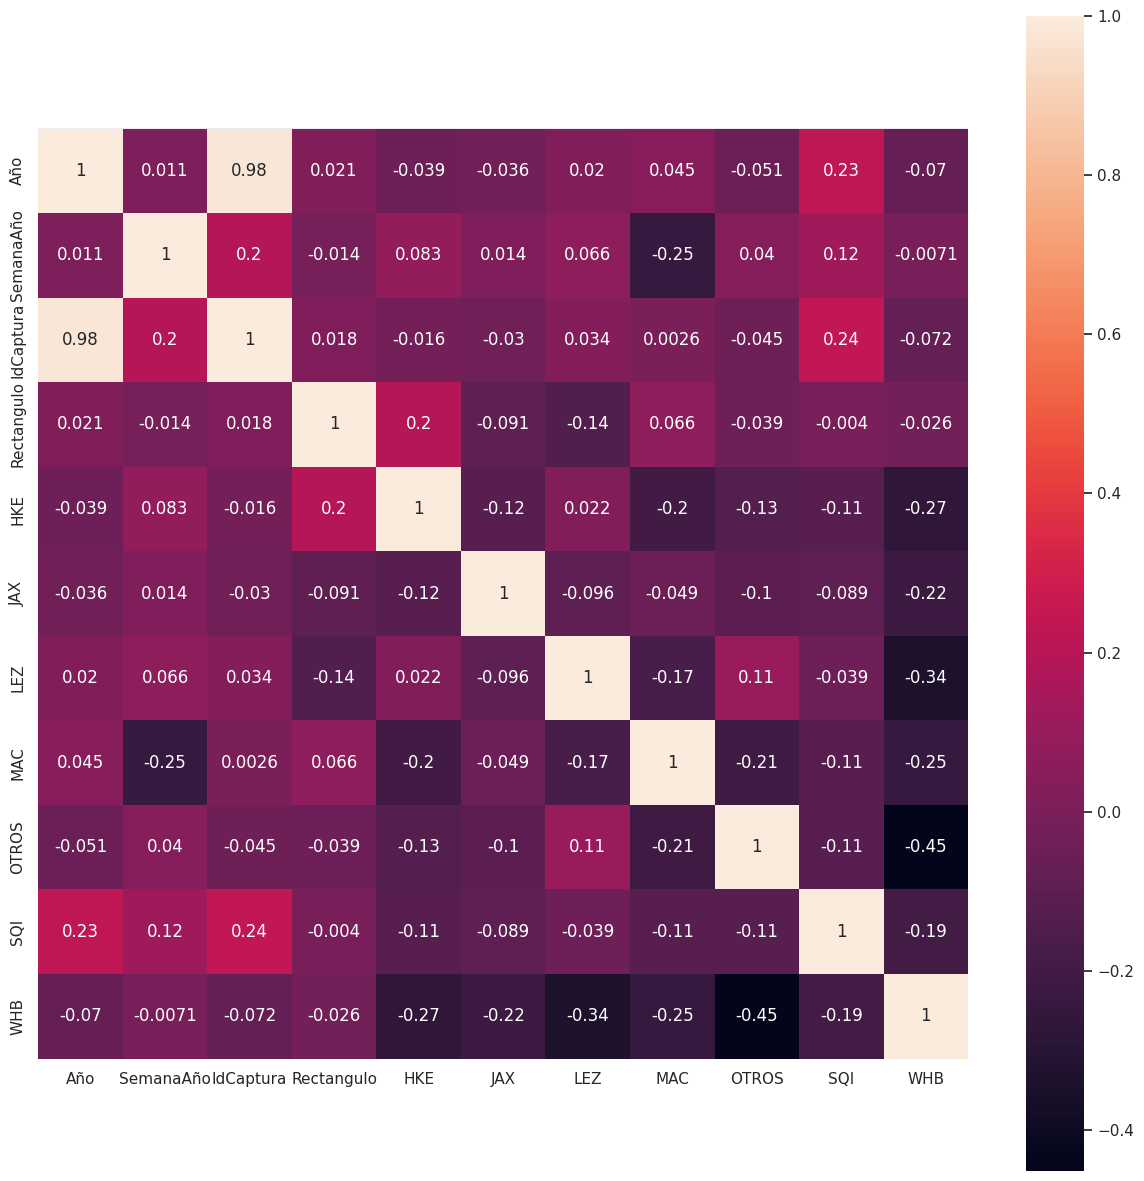

In [ ]:
#Matriz de correlación de las variables numéricas (para ver cuáles de ellas están fuertemente relacionadas):
sns.set()
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), square=True, annot=True)

#### Balanceo de datos

In [ ]:
#¿Datos balanceados?
print(df.groupby('Año').size().sort_values())
print('#---------------------------#')
print(df.groupby('SemanaAño').size().sort_values())
print('#---------------------------#')
print(df.groupby('RE').size().sort_values())
# print('#---------------------------#')
# print(df.groupby('HKE').size().sort_values())
# print('#---------------------------#')
# print(df.groupby('JAX').size().sort_values())
# print('#---------------------------#')
# print(df.groupby('LEZ').size().sort_values())
# print('#---------------------------#')
# print(df.groupby('MAC').size().sort_values())
# print('#---------------------------#')
# print(df.groupby('OTROS').size().sort_values())
# print('#---------------------------#')
# print(df.groupby('SQI').size().sort_values())
# print('#---------------------------#')
# print(df.groupby('WHB').size().sort_values())


Año
2019    10941
2020    10982
2022    11169
2018    12091
2021    12123
dtype: int64
#---------------------------#
SemanaAño
53      43
52     500
51     778
1      844
50     895
45     903
49     927
44     937
47     953
41     958
40     961
42     991
46     997
3      999
5     1004
28    1022
39    1022
31    1023
34    1039
37    1050
43    1051
38    1055
30    1067
36    1071
32    1071
29    1076
4     1078
35    1079
27    1094
2     1097
10    1097
33    1097
48    1104
25    1135
7     1175
15    1183
6     1191
26    1210
24    1221
23    1232
20    1238
22    1250
19    1260
18    1268
14    1272
8     1278
9     1286
11    1303
16    1308
21    1311
17    1341
13    1418
12    1543
dtype: int64
#---------------------------#
RE
'18E7'        1
'17E6'        1
'17E8'        1
'17E5'        2
'15E6'        3
'15E4'        6
'17E0'       11
'17E3'       46
'15E5'      483
'17E7'      571
'16E0'     1117
'17E2'     1197
'16E5'     1314
'16E6'     1742
'15E1'     1939
'16E

#### Boxplots e histogramas

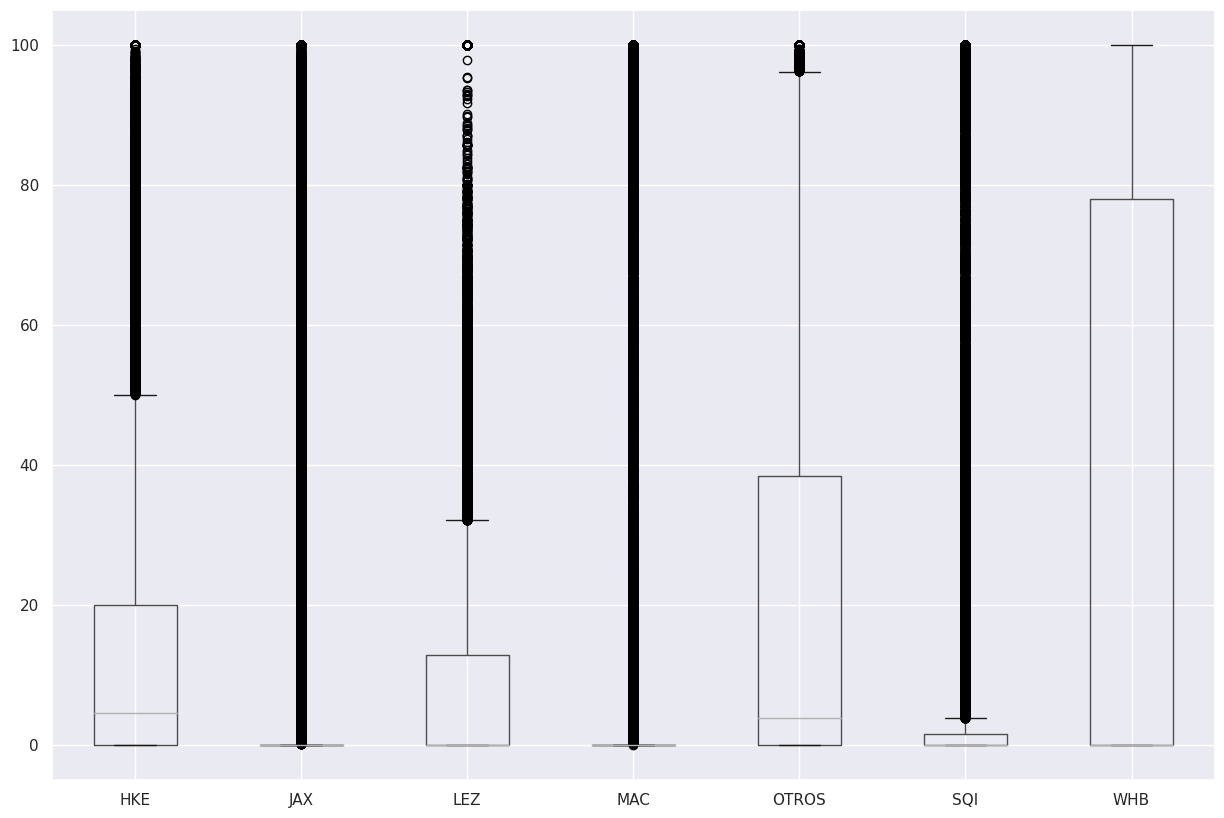

In [ ]:
#Boxplot de las especies:
boxplot = df.boxplot(['HKE', 'JAX', 'LEZ', 'MAC', 'OTROS', 'SQI', 'WHB'],grid=True,figsize=(15,10))
boxplot.plot()

plt.show()

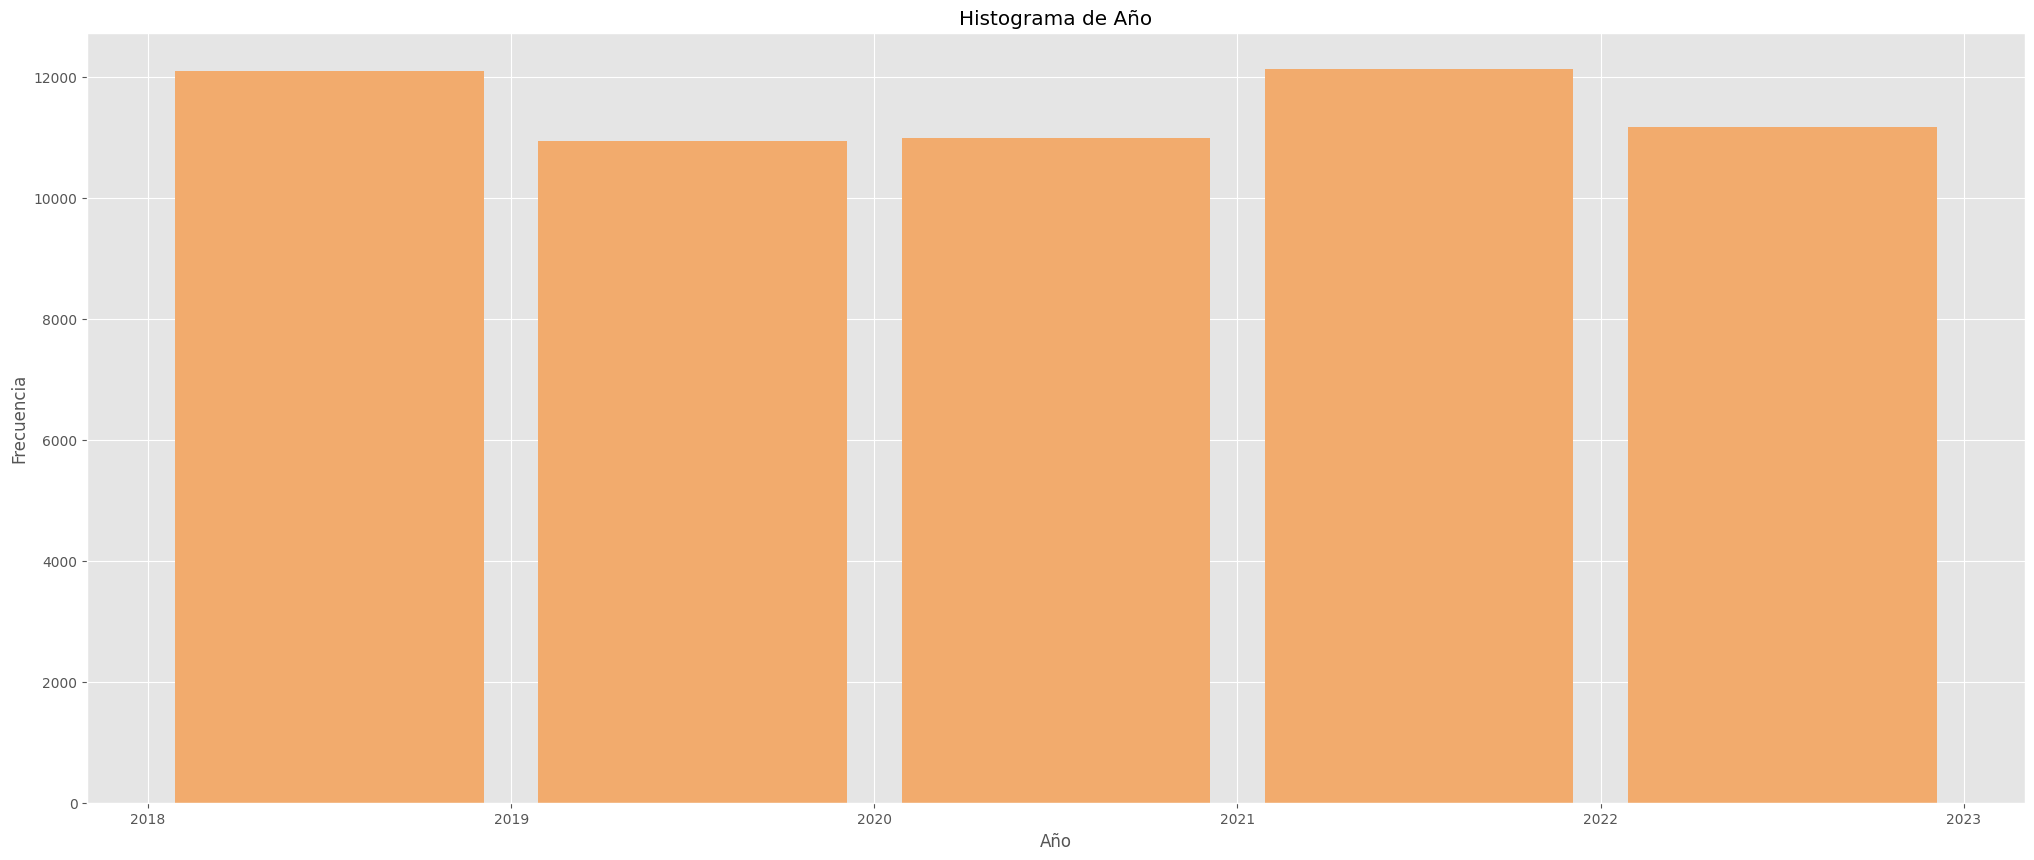

In [ ]:
#Histograma de Año
intervalos =  range(2018,2024)
plt.hist(x=df['Año'], bins=intervalos, color='#F2AB6D', rwidth=0.85)
plt.title('Histograma de Año')
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.xticks(intervalos)

plt.show()

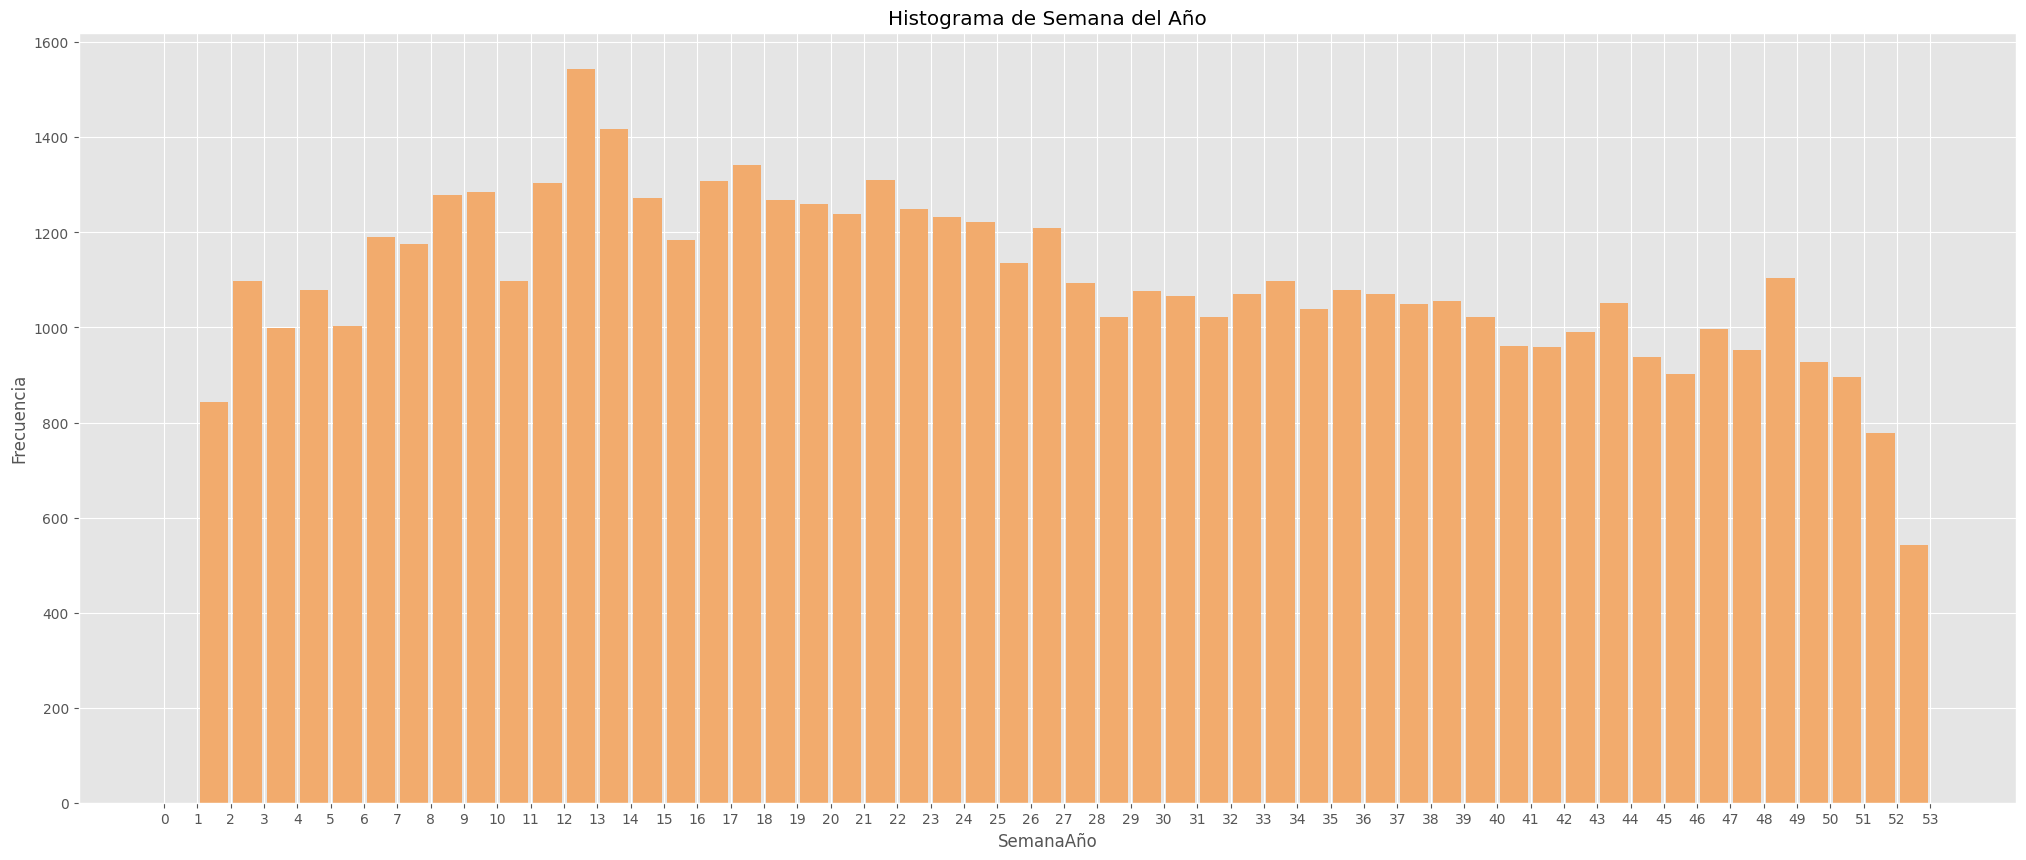

In [ ]:
#Histograma de Semana del Año
intervalos =  range(0,54)
plt.hist(x=df['SemanaAño'], bins=intervalos, color='#F2AB6D', rwidth=0.85)
plt.title('Histograma de Semana del Año')
plt.xlabel('SemanaAño')
plt.ylabel('Frecuencia')
plt.xticks(intervalos)

plt.show()

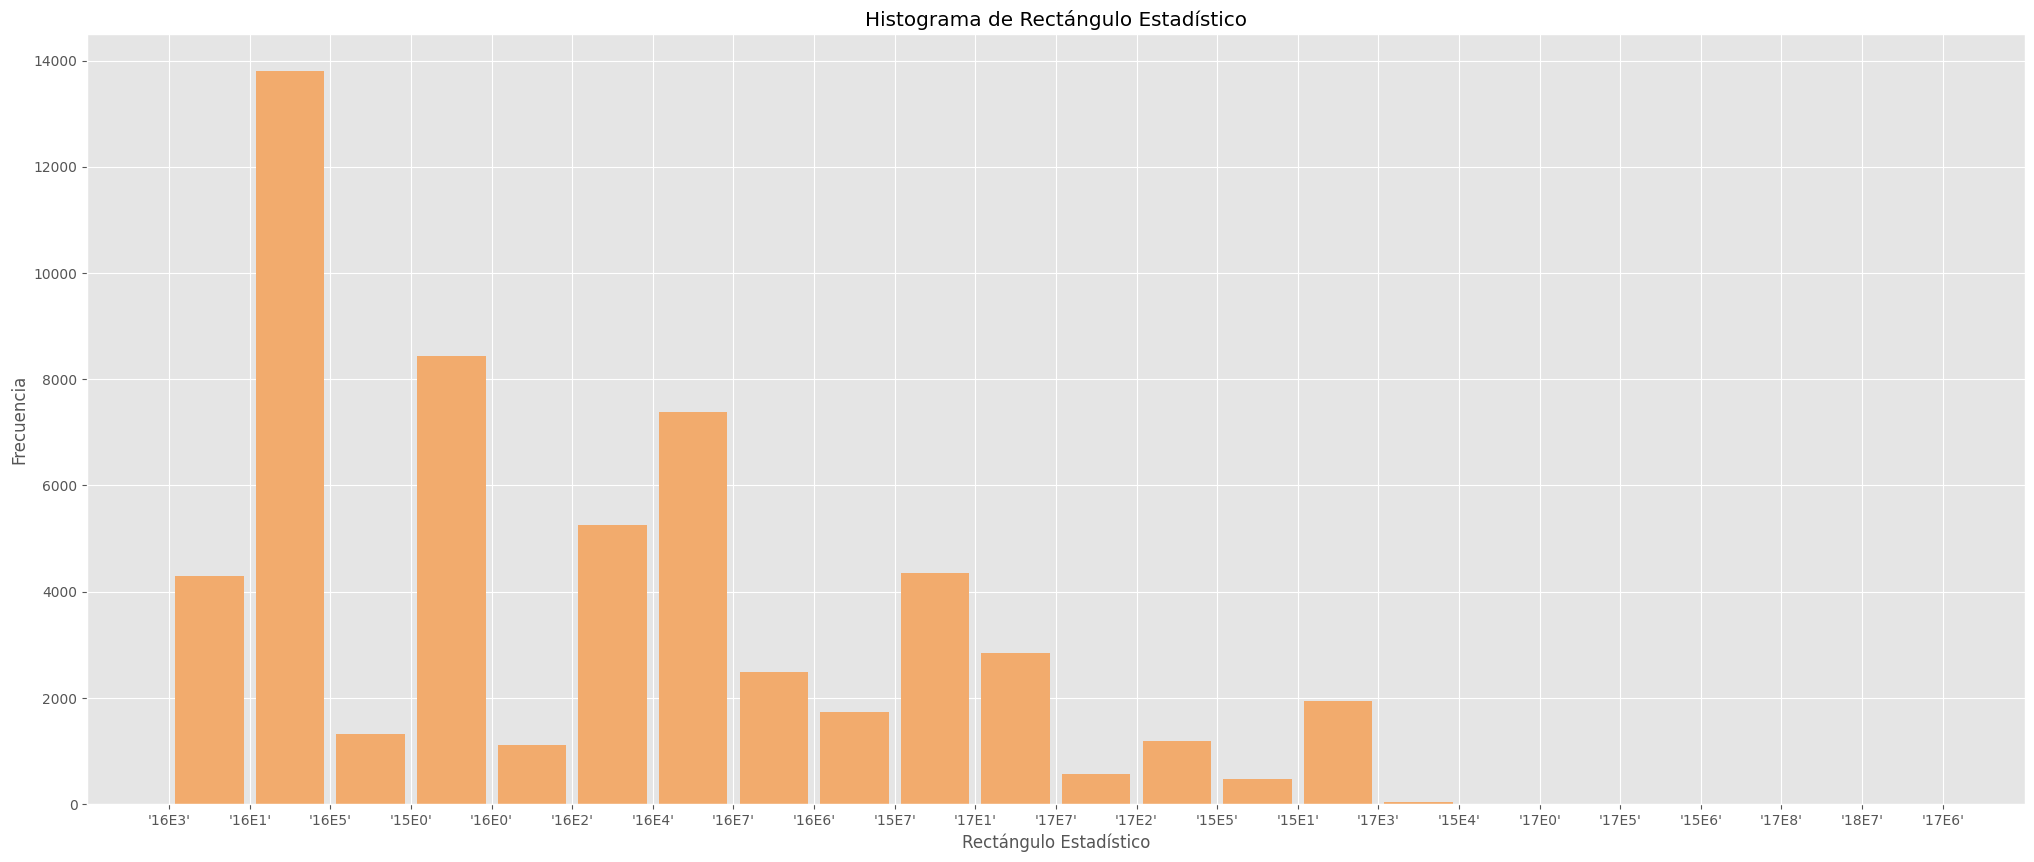

In [ ]:
#Histograma de Rectángulo Estadístico
intervalos =  range(0,23)#57306)
plt.hist(x=df['RE'], bins=intervalos, color='#F2AB6D', rwidth=0.85)
plt.title('Histograma de Rectángulo Estadístico')
plt.xlabel('Rectángulo Estadístico')
plt.ylabel('Frecuencia')
plt.xticks(intervalos)

plt.show()

## PREPARACIÓN DE DATOS

#### Aplicación de filtros

In [ ]:
#Filtro de Rectángulo Estadístico
df = df.loc[(df['RE'] == "'16E1'") | (df['RE'] == "'15E0'") | (df['RE'] == "'16E4'")]

In [ ]:
df.shape

(29634, 12)

In [ ]:
#Filtro de Semana del Año
df = df.loc[(df['SemanaAño'] < 53)]

In [ ]:
df.shape

(29624, 12)

#### Eliminación de variables

In [ ]:
#Eliminación de variables:
df = df.drop(['Año','SemanaAño','IdCaptura','Rectangulo','RE'],axis=1)
df.head()

,HKE,JAX,LEZ,MAC,OTROS,SQI,WHB
2,7.39,0.00,0.00,0.0,0.00,0.0,92.61
5,0.00,0.00,0.00,0.0,0.00,0.0,100.00
8,4.91,0.00,0.00,0.0,0.00,0.0,95.09
11,4.96,26.94,0.00,0.0,10.64,5.7,51.76
14,4.54,0.00,4.01,0.0,91.45,0.0,0.00


In [ ]:
df.shape

(29624, 7)

#### Normalización de datos

In [ ]:
#Normalización
min_max_scaler = preprocessing.MinMaxScaler()
# fn = min_max_scaler.fit_transform(ohe)
fn = min_max_scaler.fit_transform(df)
fn[:3]

array([[0.0739, 0.    , 0.    , 0.    , 0.    , 0.    , 0.9261],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 1.    ],
       [0.0491, 0.    , 0.    , 0.    , 0.    , 0.    , 0.9509]])

In [ ]:
len(fn)

29624

## ESTUDIO DE LA TENDENCIA DEL CLUSTERING

In [ ]:
#Estadístico Hopkins
hopkins(df)

0.9857905443943918

## NÚMERO ÓPTIMO DE CLÚSTERES

A continuación se van a analizar 4 métodos:

- Método del codo (Elbow Method)

> KMeans

> MiniBatch KMeans

- Coeficiente de Silhouette
- Estadístico GAP
- Dendrogramas

Fuente:
https://jarroba.com/seleccion-del-numero-optimo-clusters/


### KMEans (52%) - Sin RE, Año, SemanaAño

Valores óptimos de los hiperparámetros con el **Método del Codo** y el **Coeficiente de Silhouette**

Aplicación de KMeans en el método del codo como aproximación inicial.

#### Random

In [ ]:
distortions = []
silhouettes = []

for i in range(2,30):
    km = KMeans(i, init='random', n_init=10, max_iter=300, tol=1e-4, random_state=rs)
    clustering = km.fit_predict(fn)
    distortions.append(round(km.inertia_,2))
    silhouettes.append(round(metrics.silhouette_score(fn, clustering),2))

**Tiempo de ejecución**: 6 min (rango (2,30) con 52% de los datos)

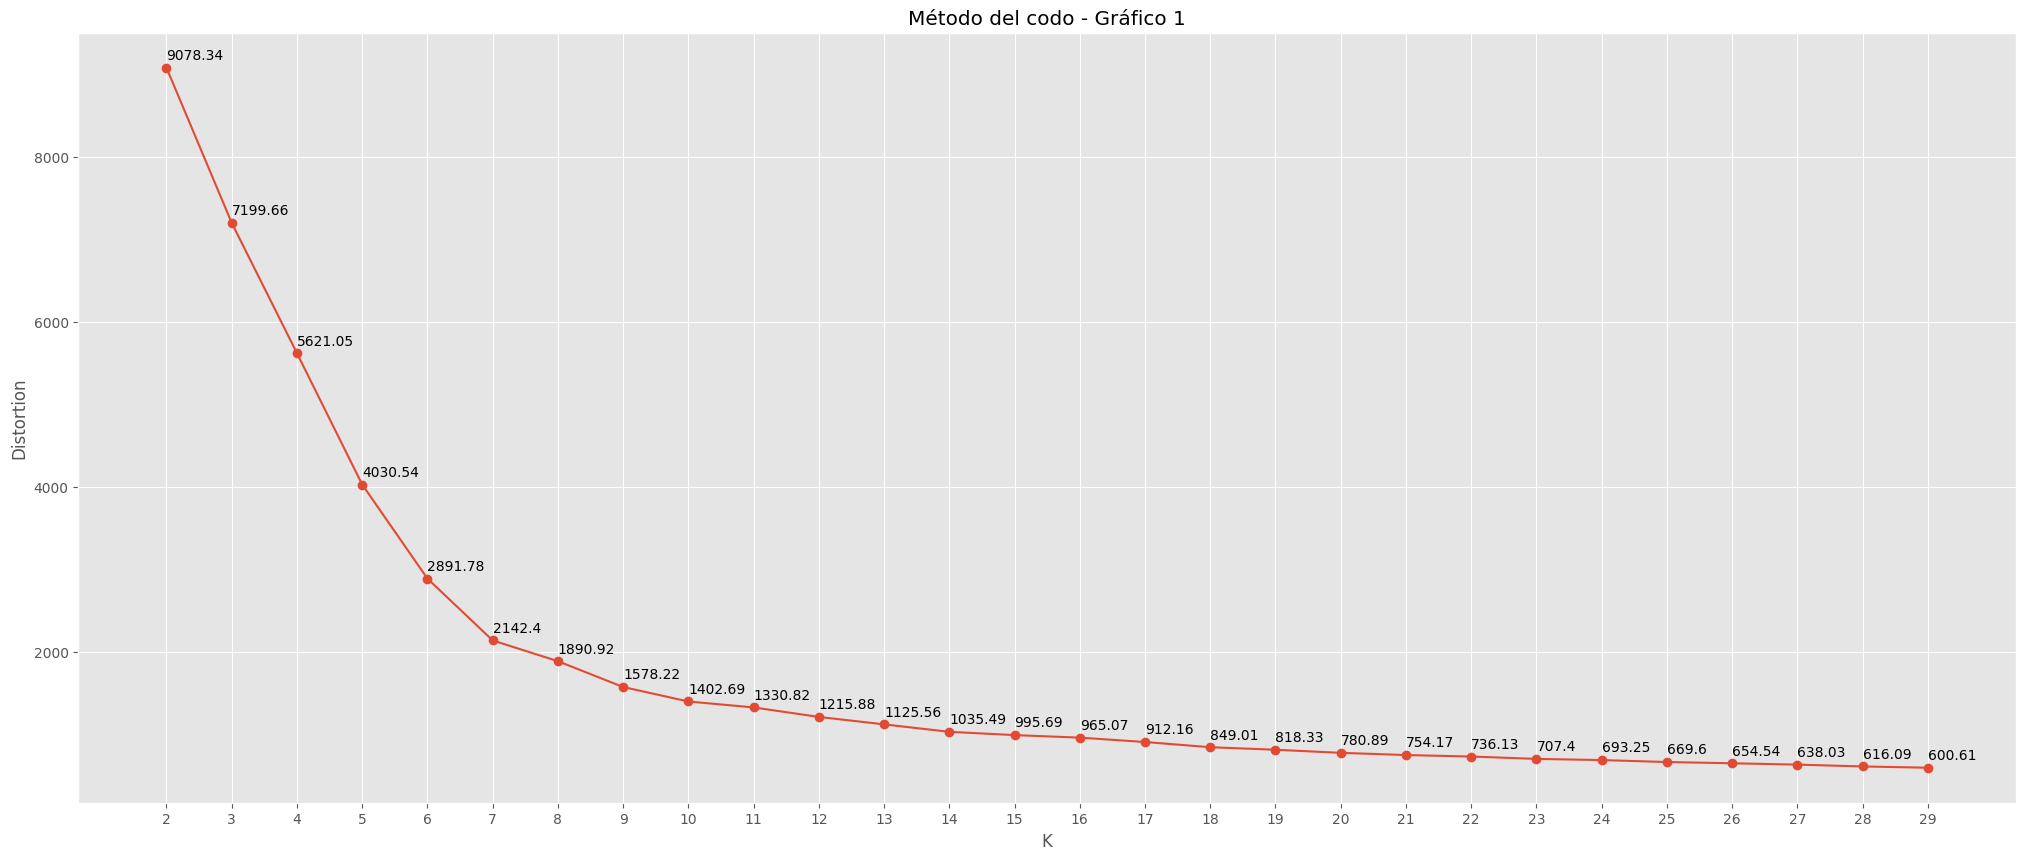

In [ ]:
plt.plot(range(2,30), distortions, marker='o')
plt.xticks(range(2,30))
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('Método del codo - Gráfico 1')
plt.grid(True)
#Se imprimen las distorsiones:
for i, label in enumerate(distortions):
  plt.annotate(label, (i + 2, distortions[i] + 100))

plt.show()

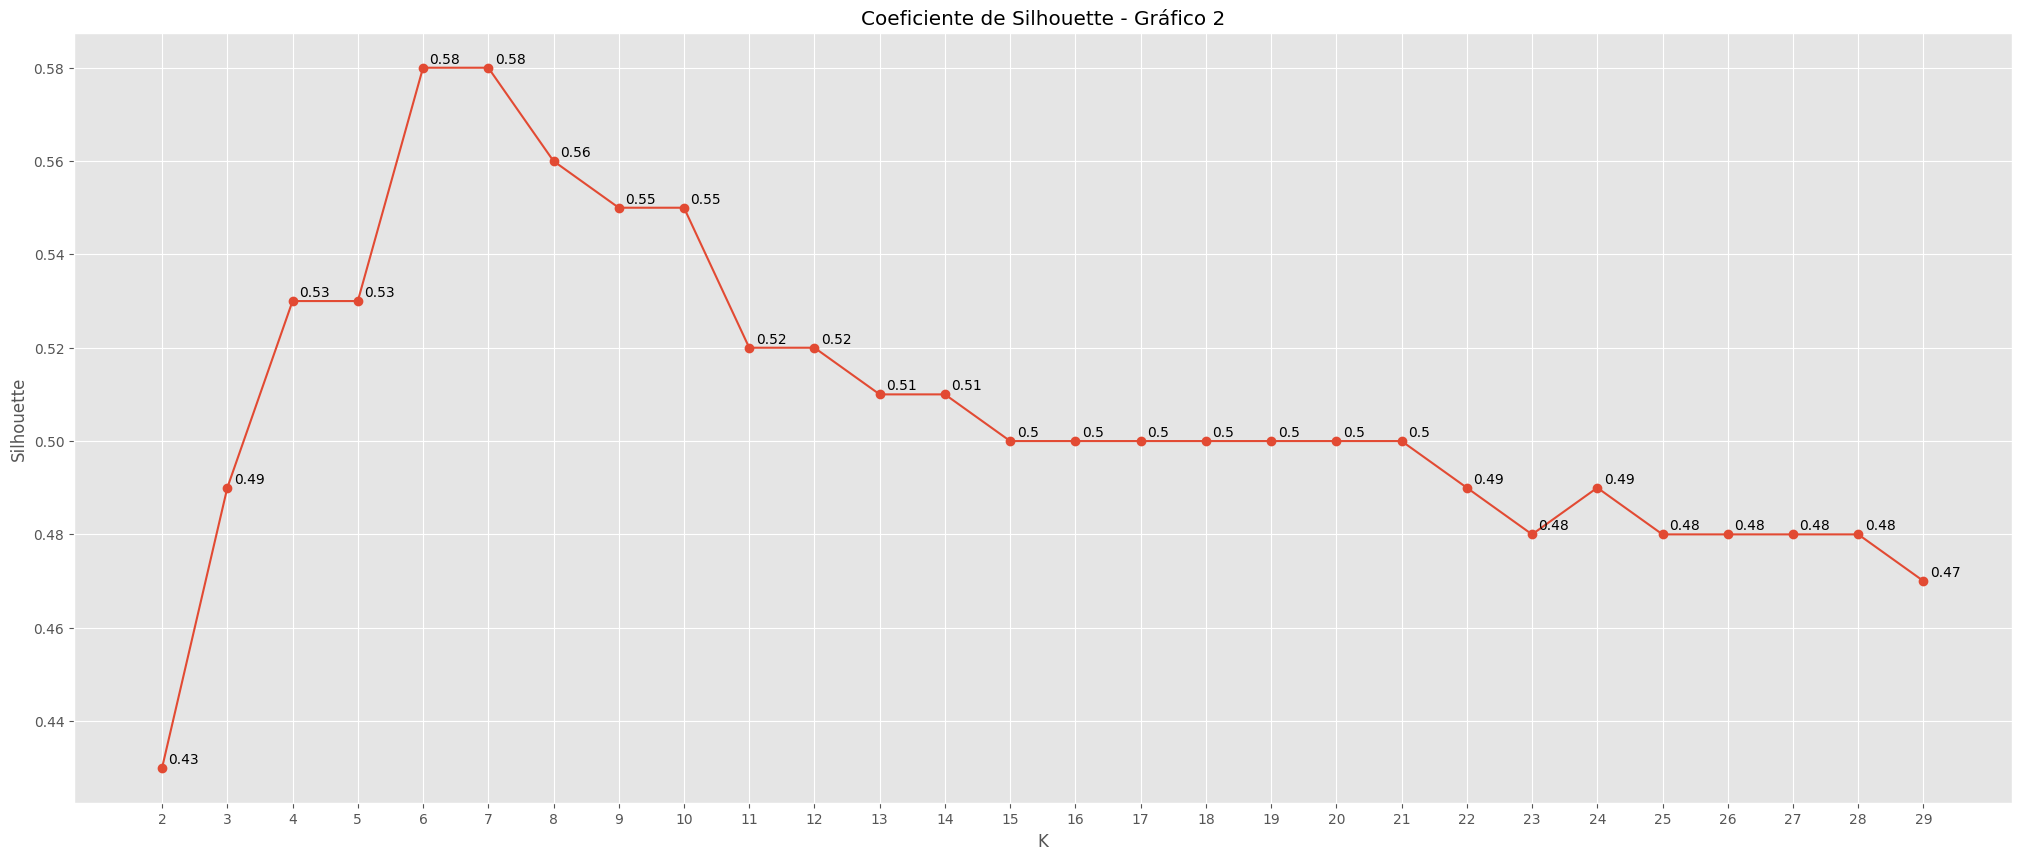

In [ ]:
plt.plot(range(2,30), silhouettes , marker='o')
plt.xticks(range(2,30))
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.title('Coeficiente de Silhouette - Gráfico 2')
plt.grid(True)
#Se imprimen los coeficientes de Silhouette:
for i, label in enumerate(silhouettes):
  plt.annotate(label, (i + 2.1, silhouettes[i] + 0.001))

plt.show()

#### KMeans++

Con K-Means++ se acelera la convergencia, según documentación:

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


In [ ]:
distortions = []
silhouettes = []

for i in range(2,30):
    km = KMeans(i, init='k-means++', n_init=1, max_iter=300, tol=1e-4, random_state=rs)
    clustering = km.fit_predict(fn)
    distortions.append(round(km.inertia_,2))
    silhouettes.append(round(metrics.silhouette_score(fn, clustering),2))

**Tiempo de ejecución**: 4 min (rango (2,30) con 52% de los datos)

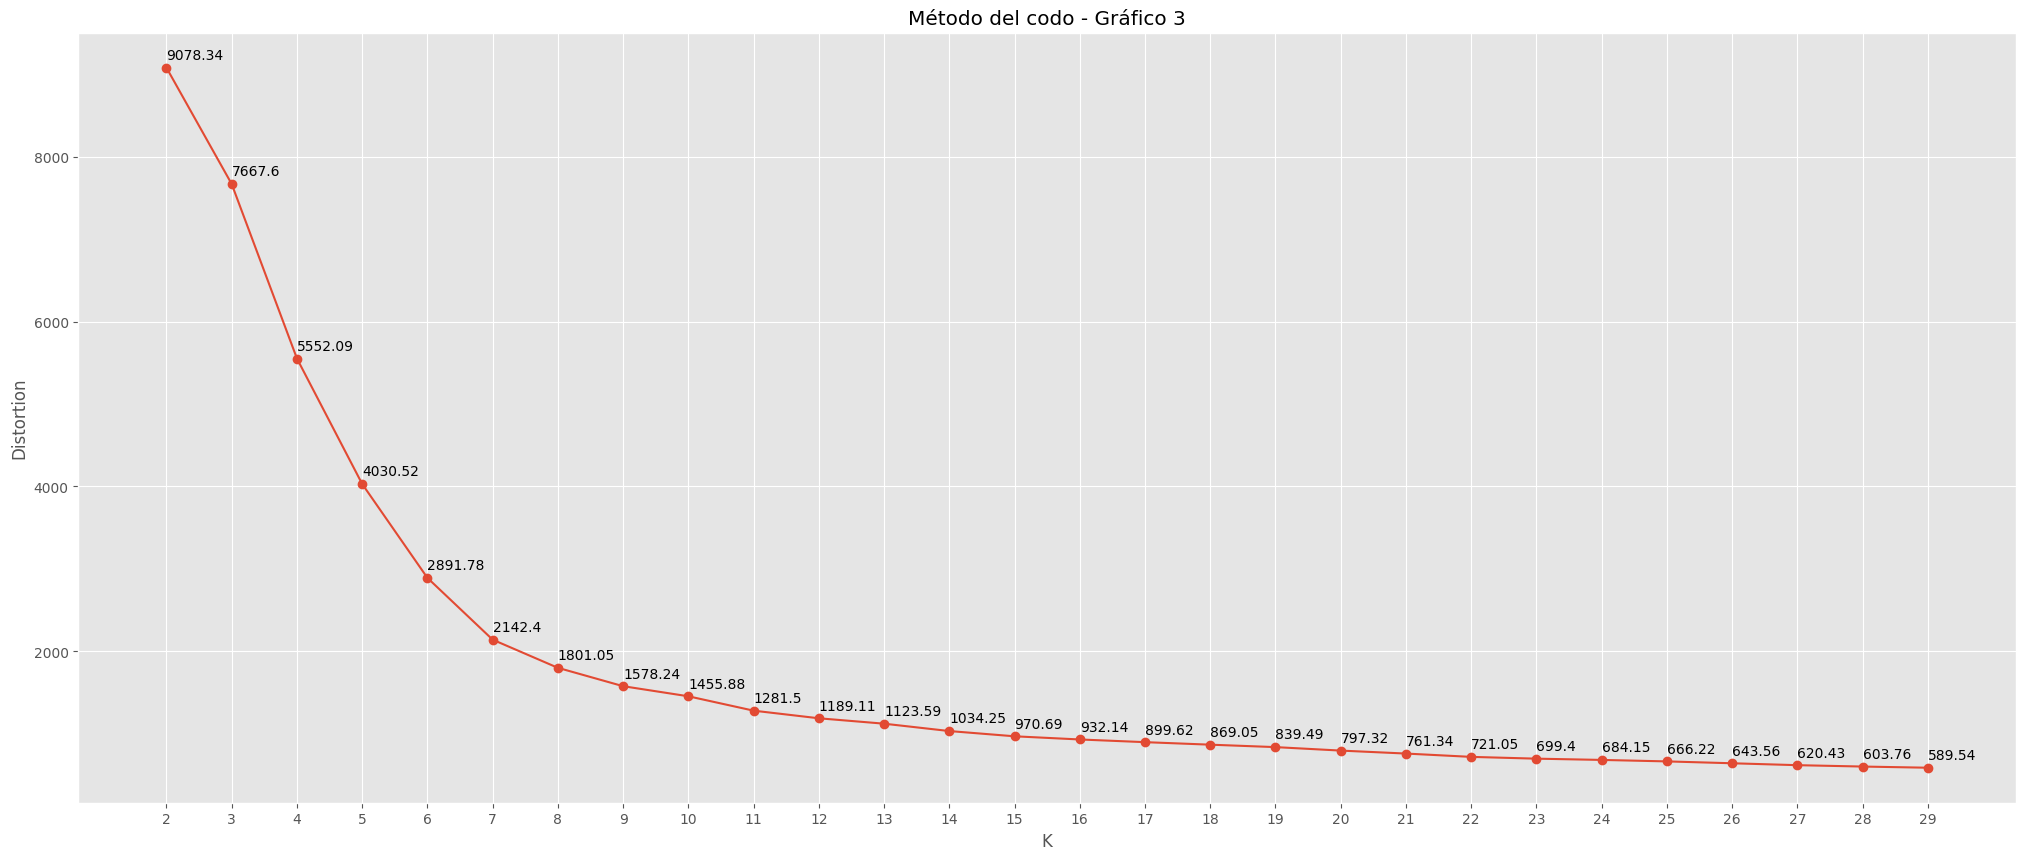

In [ ]:
plt.plot(range(2,30), distortions, marker='o')
plt.xticks(range(2,30))
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('Método del codo - Gráfico 3')
plt.grid(True)
#Se imprimen las distorsiones:
for i, label in enumerate(distortions):
  plt.annotate(label, (i + 2, distortions[i] + 100))

plt.show()

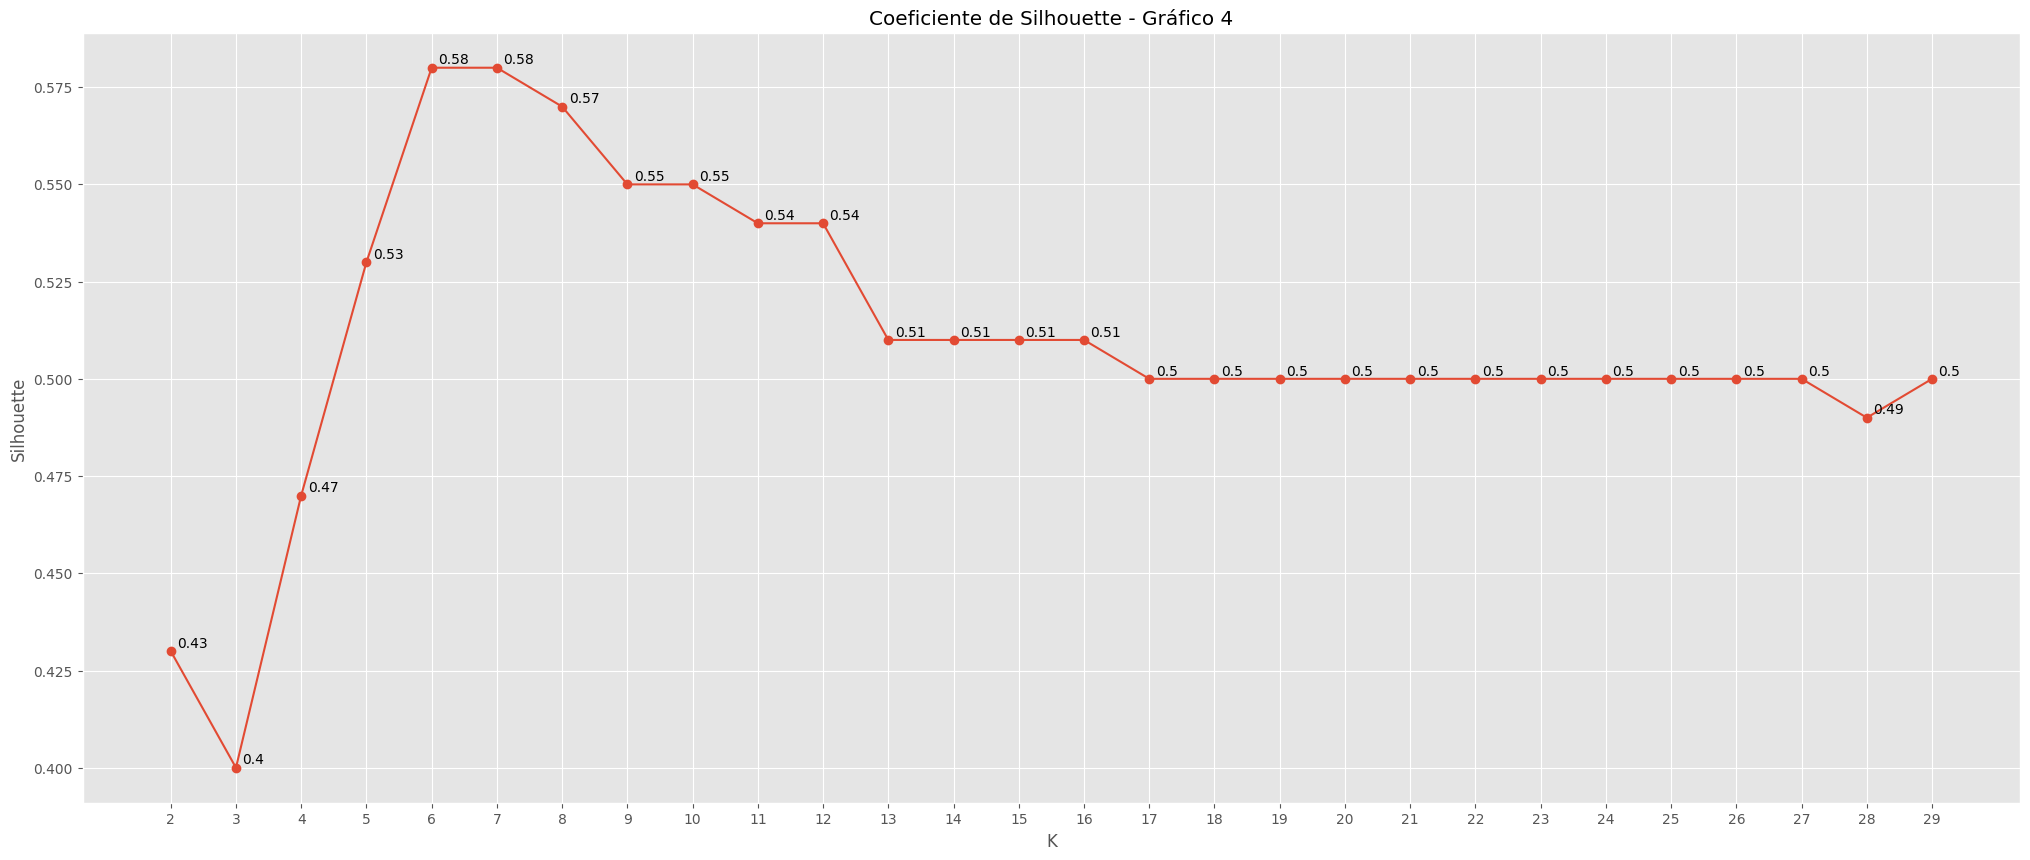

In [ ]:
plt.plot(range(2,30), silhouettes , marker='o')
plt.xticks(range(2,30))
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.title('Coeficiente de Silhouette - Gráfico 4')
plt.grid(True)
#Se imprimen los coeficientes de Silhouette:
for i, label in enumerate(silhouettes):
  plt.annotate(label, (i + 2.1, silhouettes[i] + 0.001))

plt.show()

### MiniBatch KMEans (52%) - Sin RE, Año, SemanaAño

#### Random

Aplicación de MiniBatchKMeans, más rápido que KMEans, según documentación de KMEans.

In [ ]:
distortions = []
silhouettes = []

for i in range(2,30):
    km = MiniBatchKMeans(i, init='random', n_init=10, max_iter=300, tol=1e-4, random_state=rs)
    clustering = km.fit_predict(fn)
    distortions.append(round(km.inertia_,2))
    silhouettes.append(round(metrics.silhouette_score(fn, clustering),2))

**Tiempo de ejecución**: 5 min (rango (2,30) con 52% de los datos)

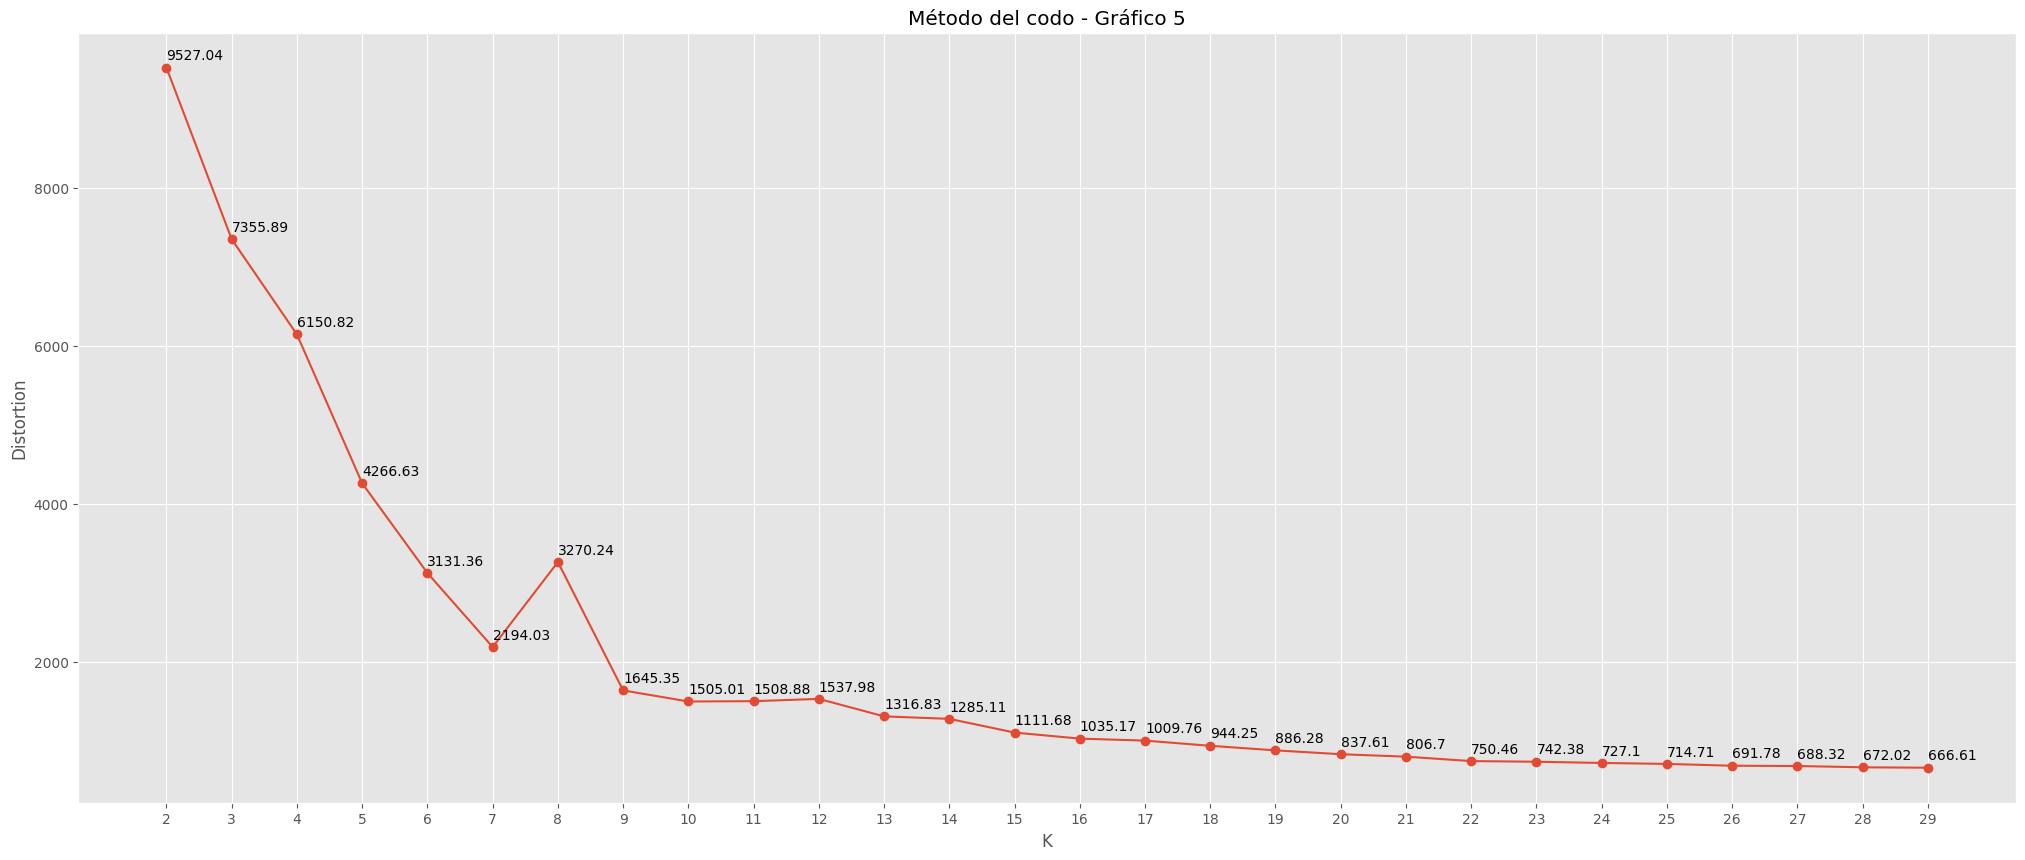

In [ ]:
plt.plot(range(2,30), distortions, marker='o')
plt.xticks(range(2,30))
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('Método del codo - Gráfico 5')
plt.grid(True)
#Se imprimen las distorsiones:
for i, label in enumerate(distortions):
  plt.annotate(label, (i + 2, distortions[i] + 100))

plt.show()

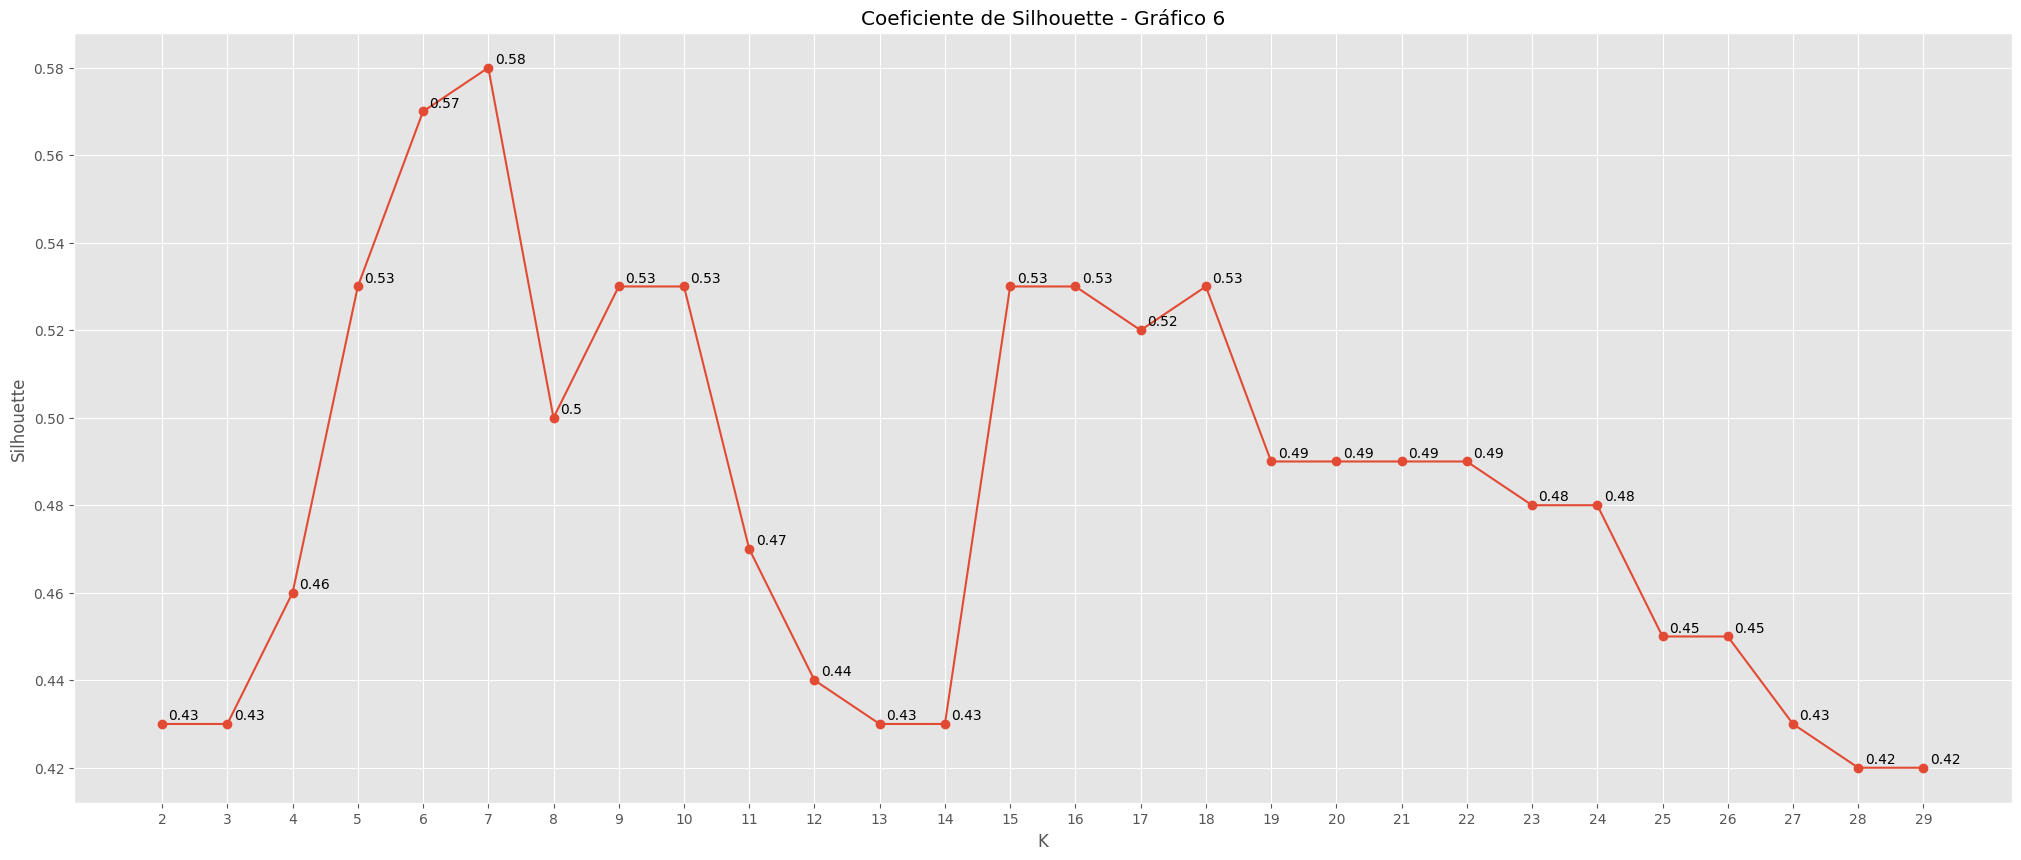

In [ ]:
plt.plot(range(2,30), silhouettes , marker='o')
plt.xticks(range(2,30))
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.title('Coeficiente de Silhouette - Gráfico 6')
plt.grid(True)
#Se imprimen los coeficientes de Silhouette:
for i, label in enumerate(silhouettes):
  plt.annotate(label, (i + 2.1, silhouettes[i] + 0.001))

plt.show()

#### KMeans++

Con KMeans++

In [ ]:
distortions = []
silhouettes = []

for i in range(2,30):
    km = MiniBatchKMeans(i, init='k-means++', n_init=1, max_iter=300, tol=1e-4, random_state=rs)
    clustering = km.fit_predict(fn)
    distortions.append(round(km.inertia_,2))
    silhouettes.append(round(metrics.silhouette_score(fn, clustering),2))

**Tiempo de ejecución**: 4 min (rango (2,30) con 52% de los datos)

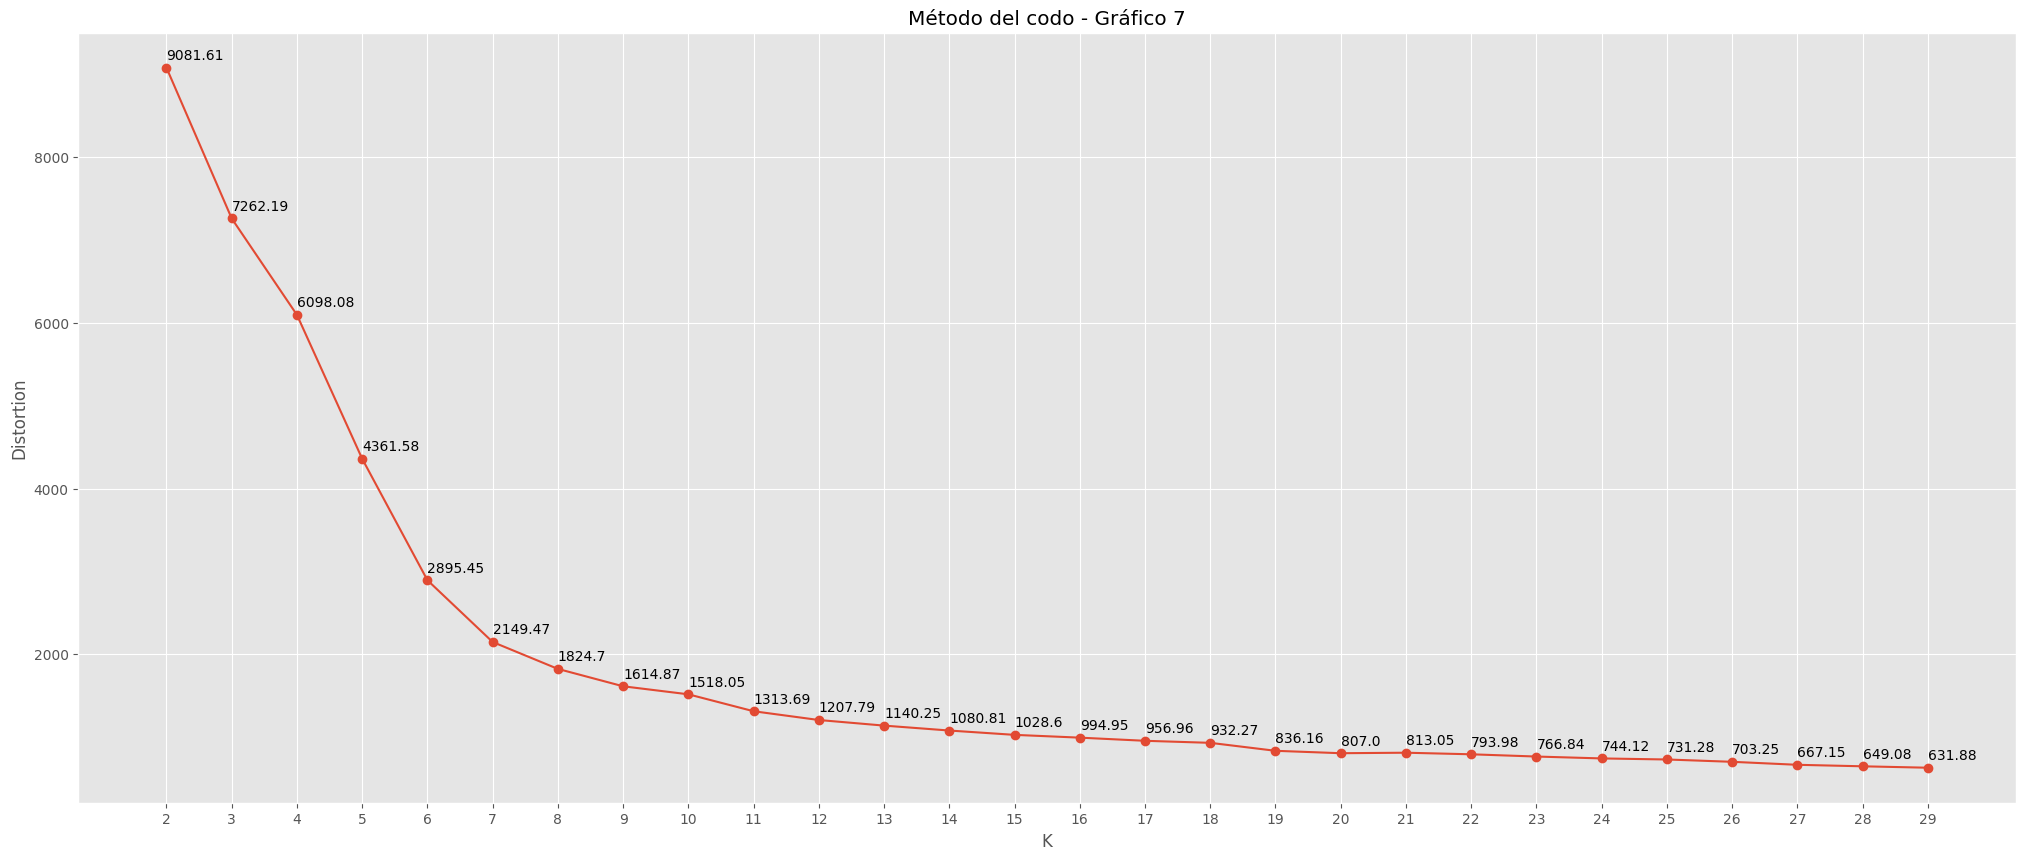

In [ ]:
plt.plot(range(2,30), distortions, marker='o')
plt.xticks(range(2,30))
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('Método del codo - Gráfico 7')
plt.grid(True)
#Se imprimen las distorsiones:
for i, label in enumerate(distortions):
  plt.annotate(label, (i + 2, distortions[i] + 100))

plt.show()

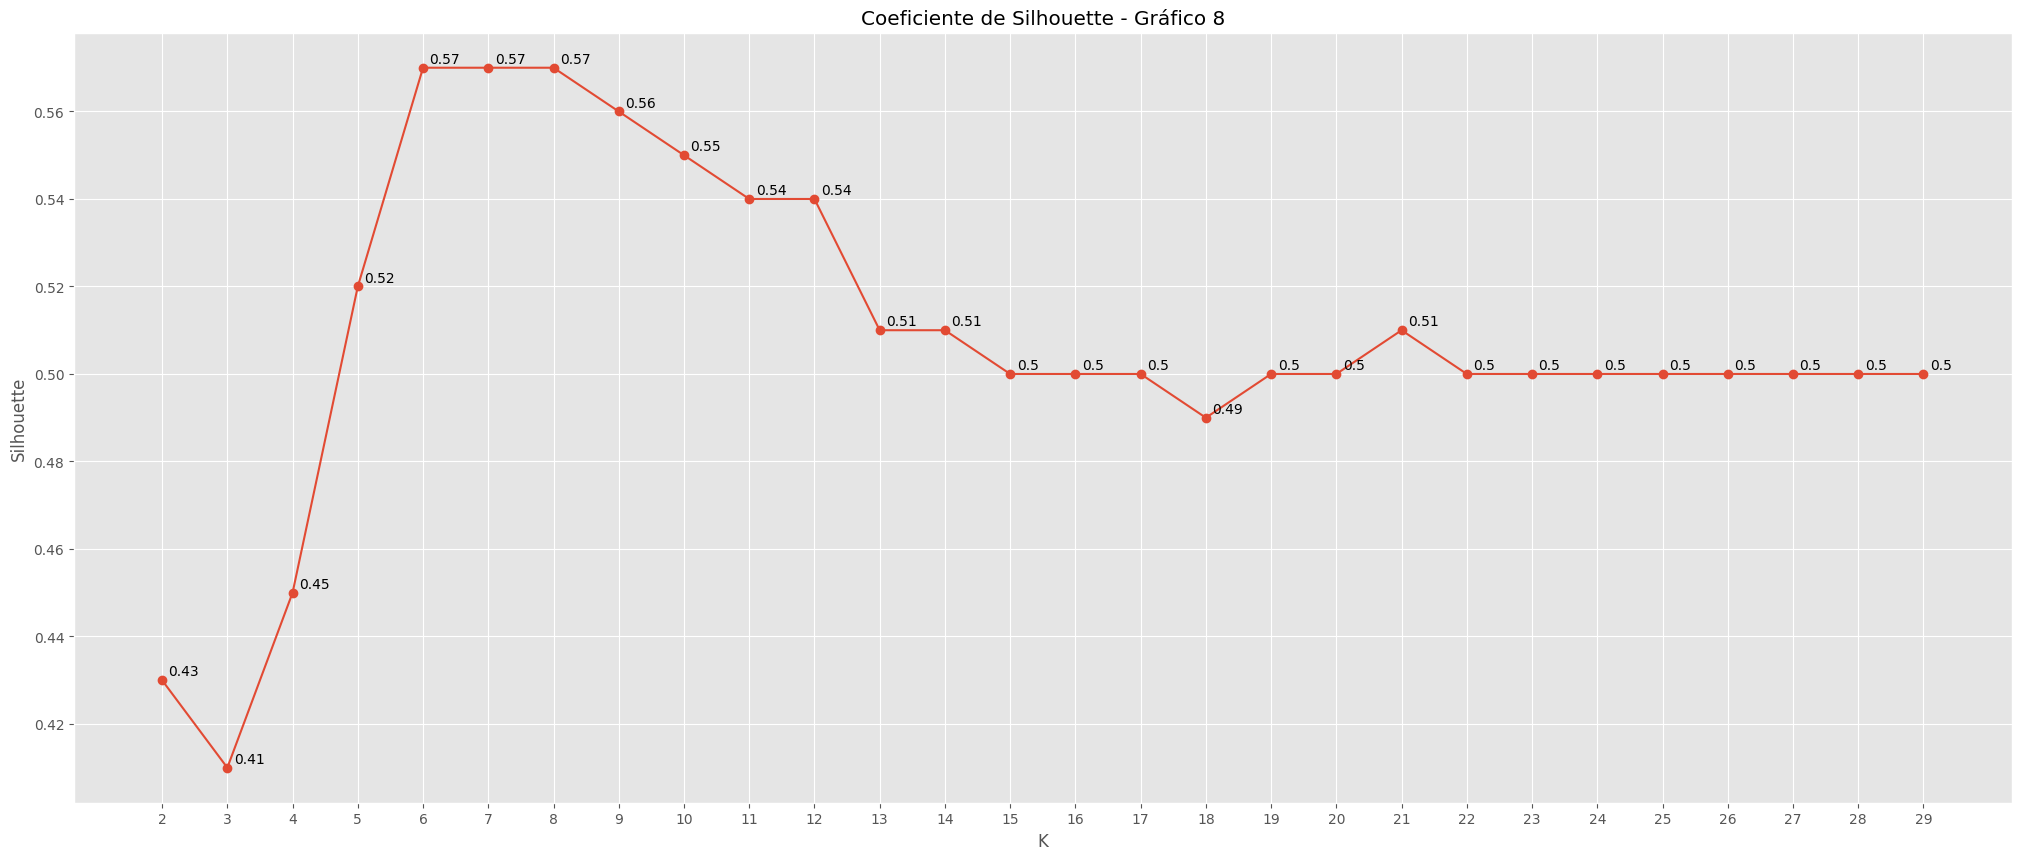

In [ ]:
plt.plot(range(2,30), silhouettes , marker='o')
plt.xticks(range(2,30))
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.title('Coeficiente de Silhouette - Gráfico 8')
plt.grid(True)
#Se imprimen los coeficientes de Silhouette:
for i, label in enumerate(silhouettes):
  plt.annotate(label, (i + 2.1, silhouettes[i] + 0.001))

plt.show()

### Estadístico GAP

#### Resultados para 52% sin RE, Año, SemanaAño:

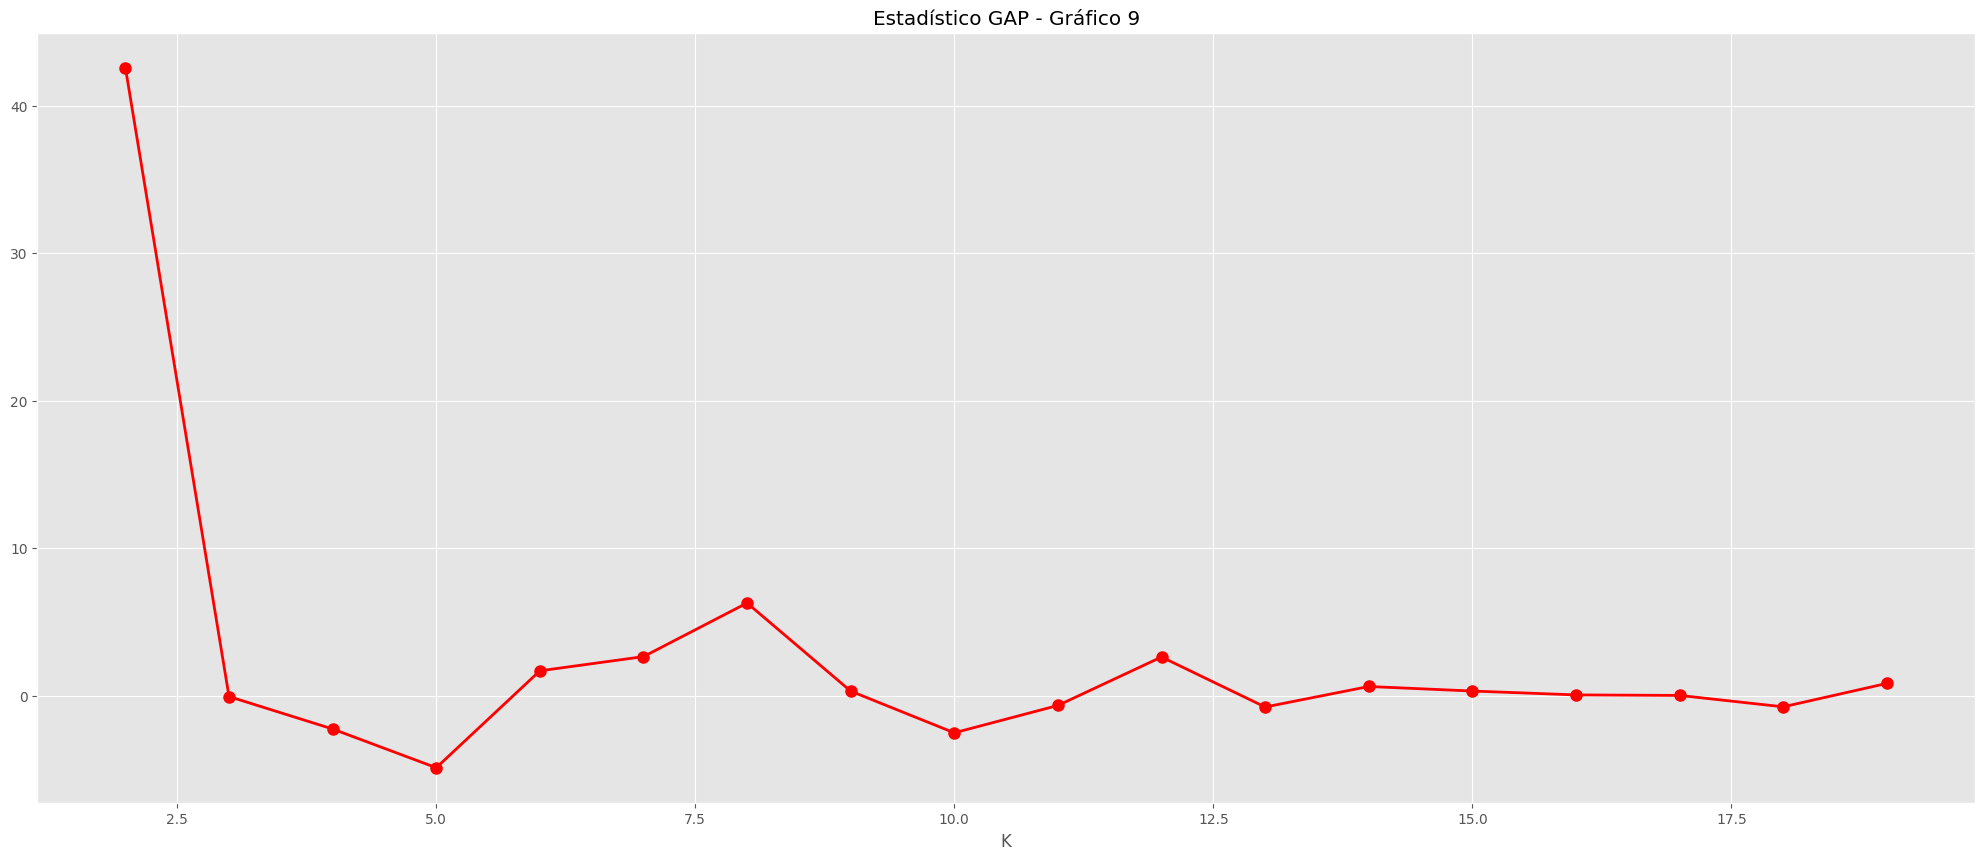

In [ ]:
Z = linkage(fn,method='ward',metric='euclidean')

# Obtain the last 20 distances between points
last = Z[-20:, 2]
num_clusters = np.arange(1, len(last) + 1)

# Calculate Gap
gap = np.diff(last, n=2)  # second derivative
plt.plot(num_clusters[:-2] + 1, gap[::-1], 'ro-', markersize=8, lw=2)
plt.title('Estadístico GAP - Gráfico 9')
plt.xlabel('K')
plt.show()

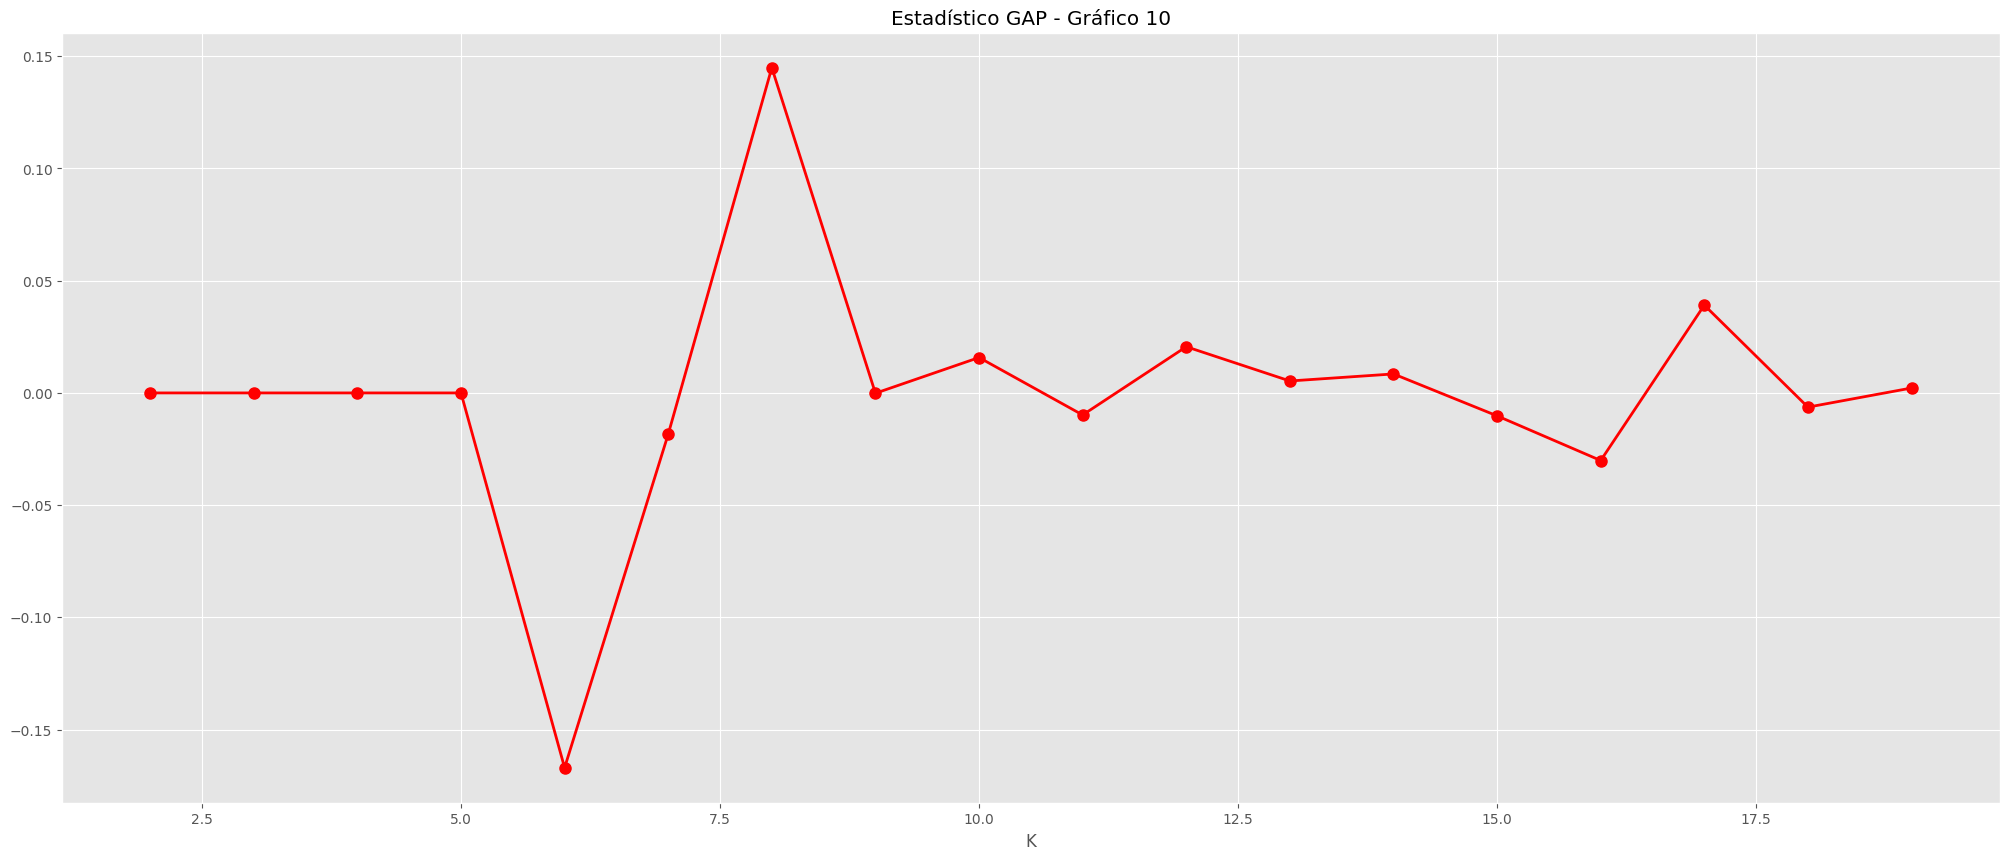

In [ ]:
Z = linkage(fn,method='complete',metric='euclidean')

# Obtain the last 20 distances between points
last = Z[-20:, 2]
num_clusters = np.arange(1, len(last) + 1)

# Calculate Gap
gap = np.diff(last, n=2)  # second derivative
plt.plot(num_clusters[:-2] + 1, gap[::-1], 'ro-', markersize=8, lw=2)
plt.title('Estadístico GAP - Gráfico 10')
plt.xlabel('K')
plt.show()

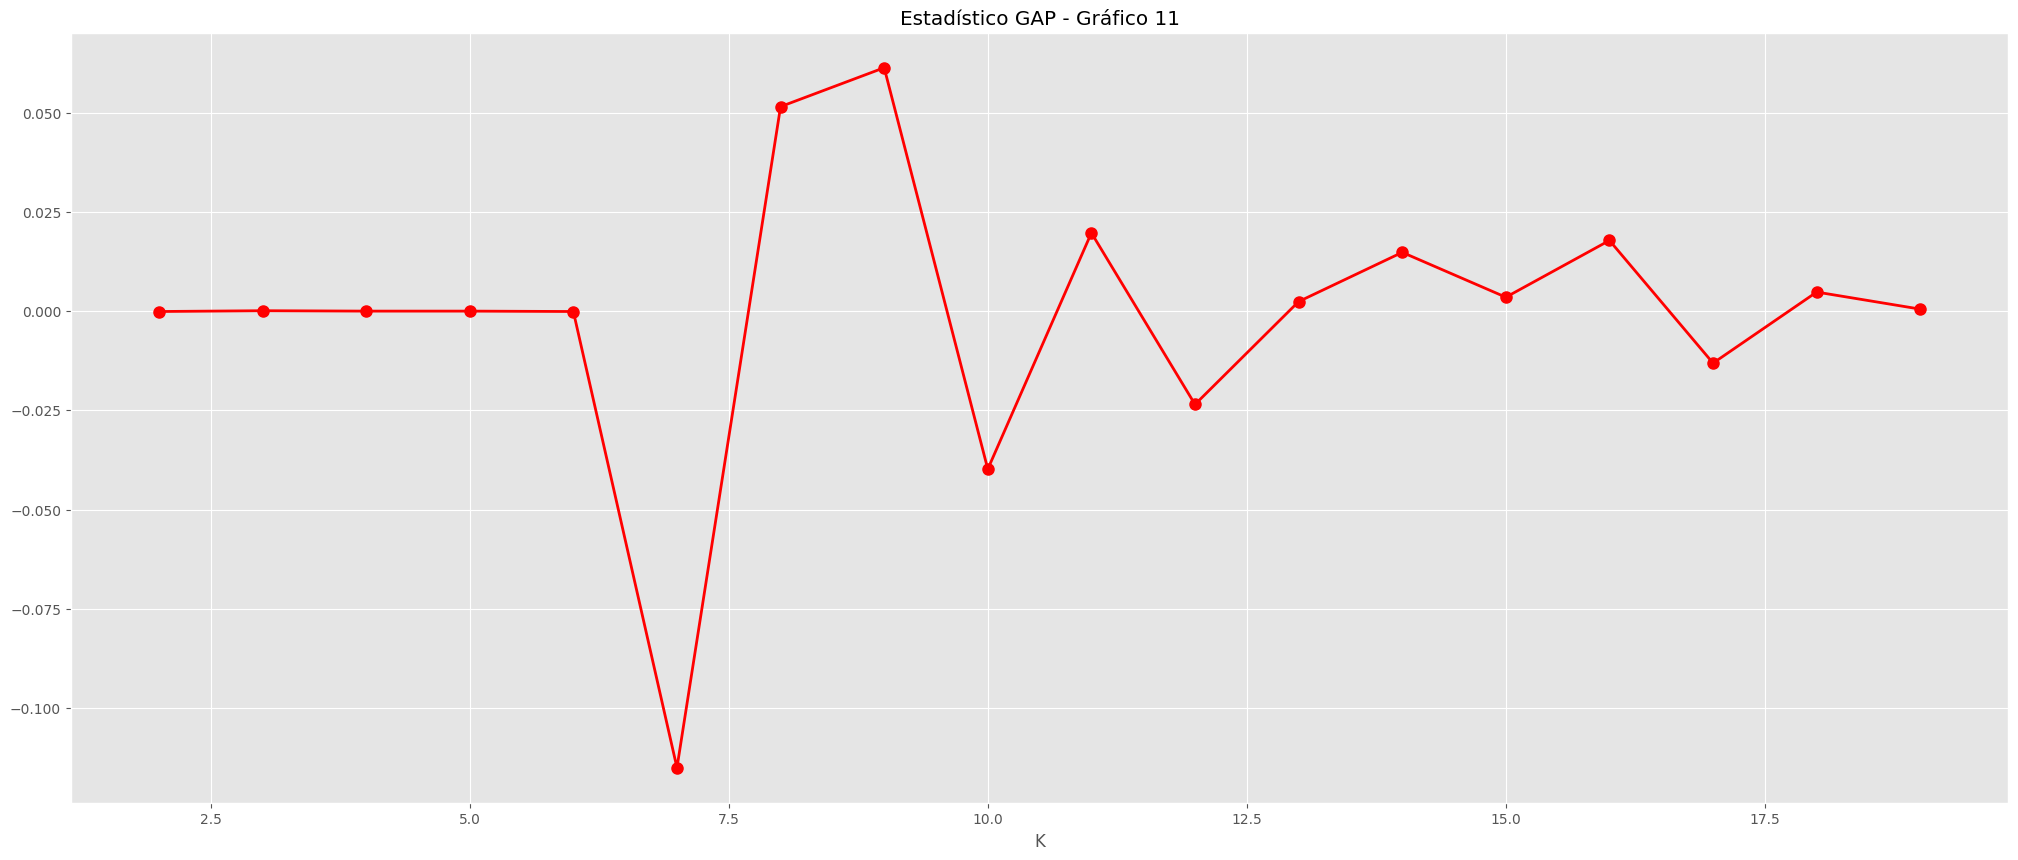

In [ ]:
Z = linkage(fn,method='complete',metric='cityblock')

# Obtain the last 20 distances between points
last = Z[-20:, 2]
num_clusters = np.arange(1, len(last) + 1)

# Calculate Gap
gap = np.diff(last, n=2)  # second derivative
plt.plot(num_clusters[:-2] + 1, gap[::-1], 'ro-', markersize=8, lw=2)
plt.title('Estadístico GAP - Gráfico 11')
plt.xlabel('K')
plt.show()

### Dendrograma

#### Resultados para 52% sin RE, Año, SemanaAño:

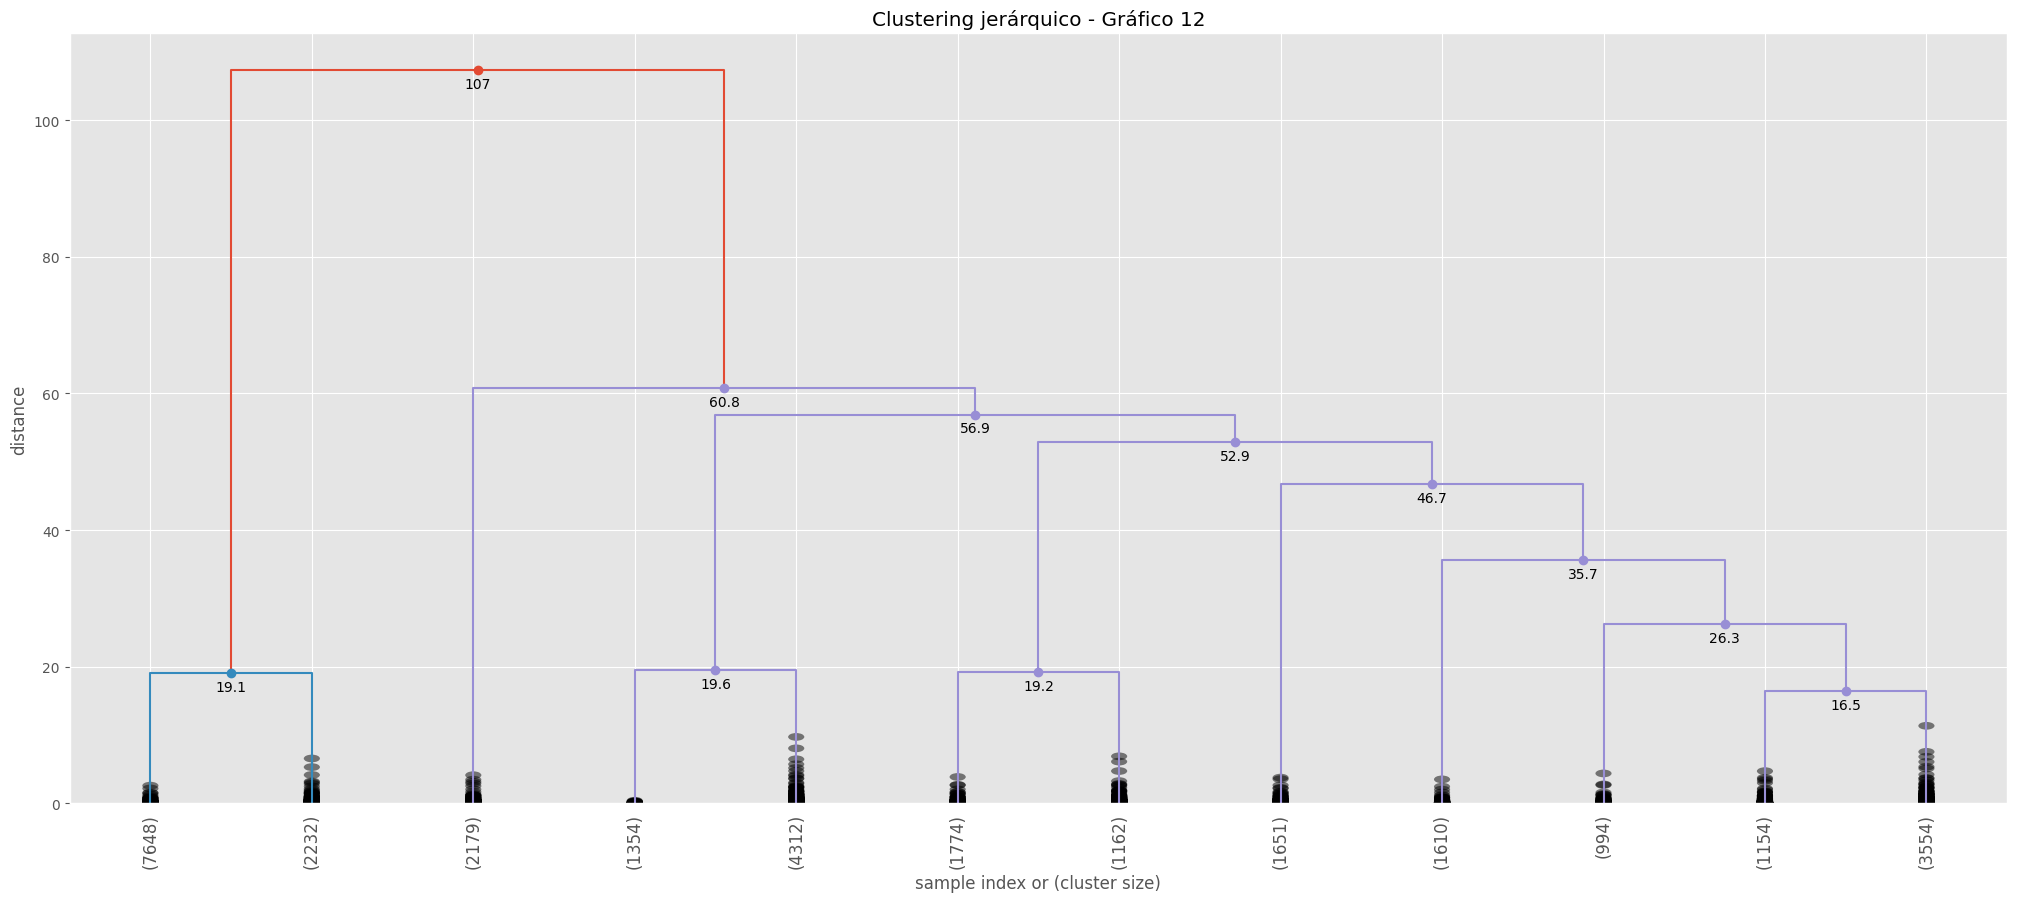

In [ ]:
Z = linkage(fn,method='ward',metric='euclidean')
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,  # useful in small plots so annotations don't overlap
    #max_d=d_max,  # plot a horizontal cut-off line
)
plt.title('Clustering jerárquico - Gráfico 12')
plt.show()

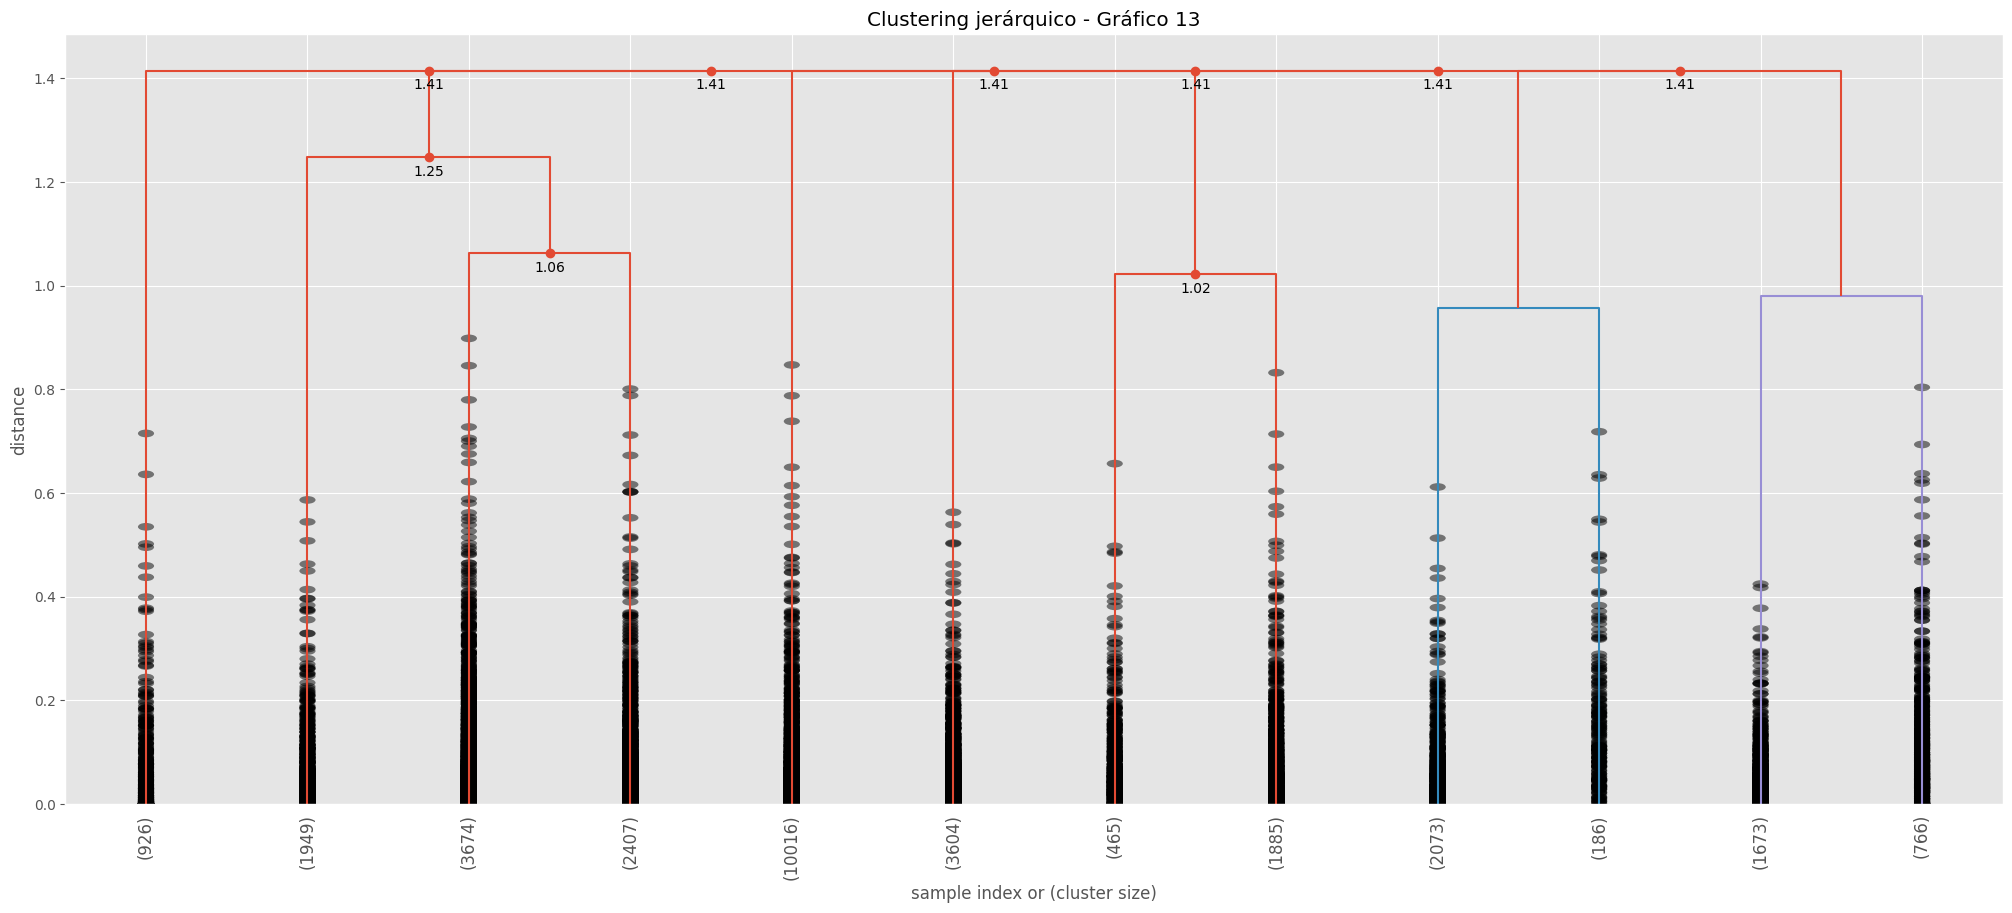

In [ ]:
Z = linkage(fn,method='complete',metric='euclidean')
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,  # useful in small plots so annotations don't overlap
    #max_d=d_max,  # plot a horizontal cut-off line
)
plt.title('Clustering jerárquico - Gráfico 13')
plt.show()

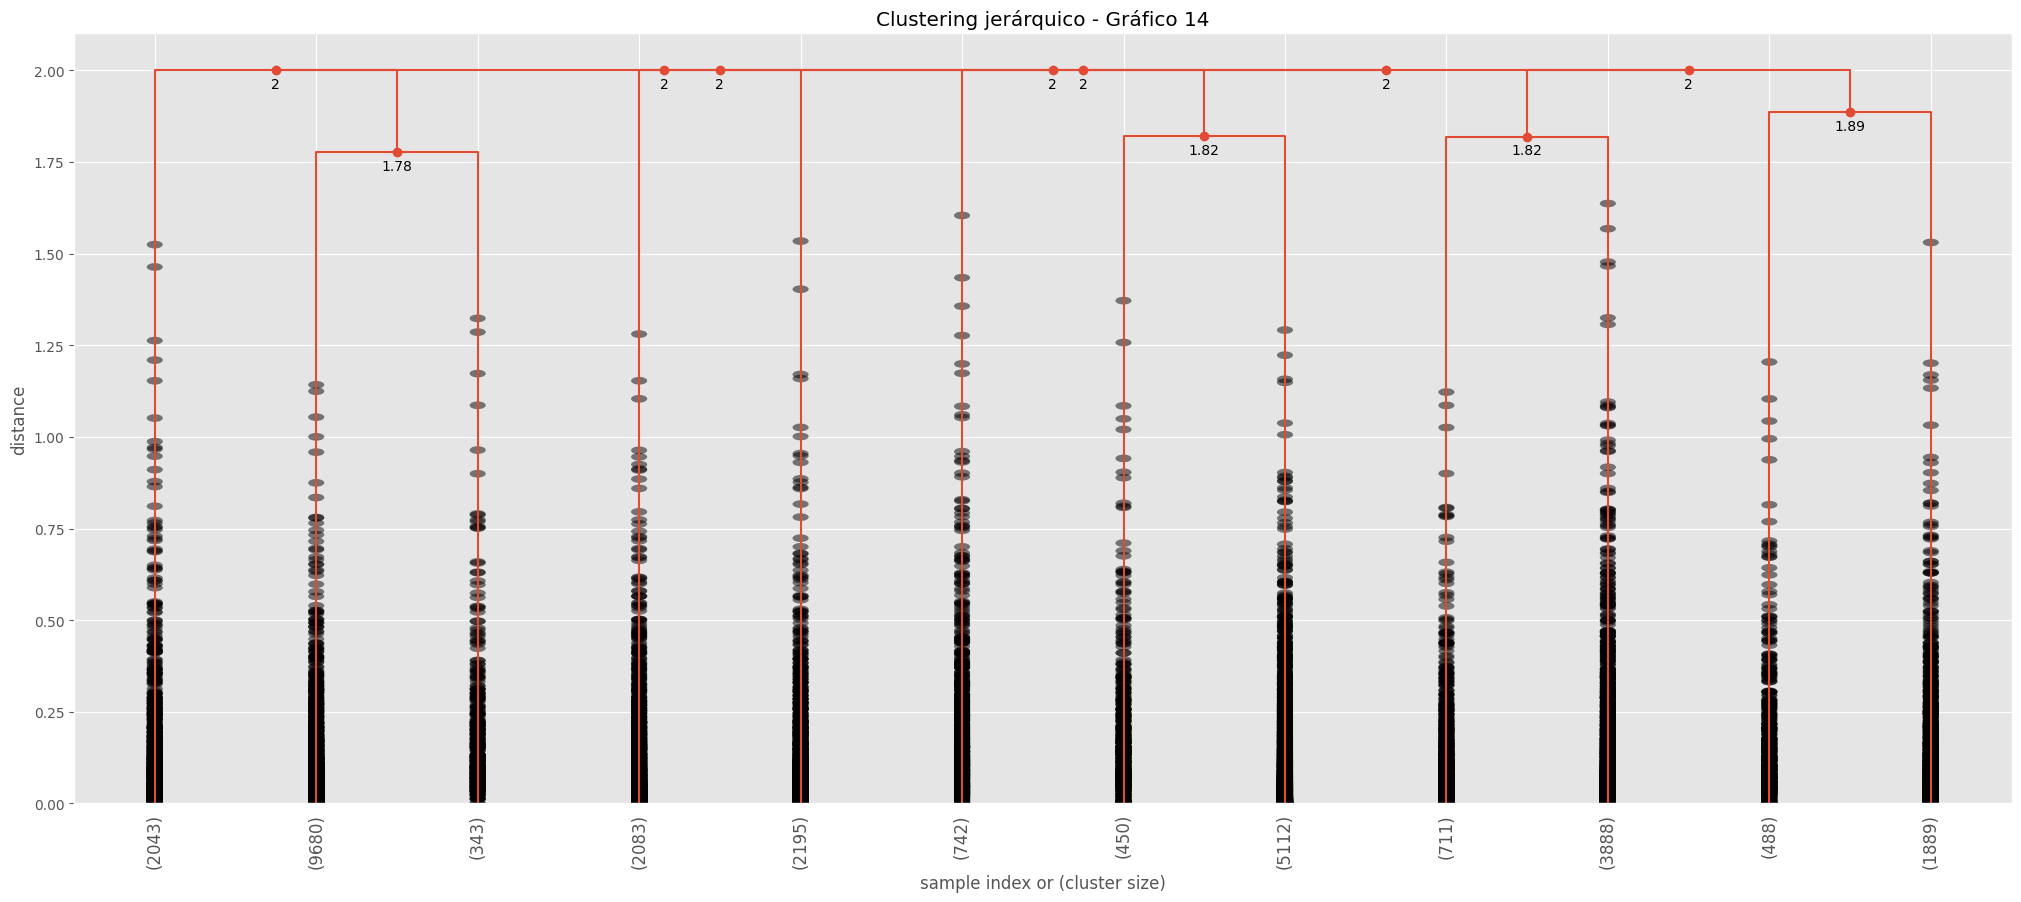

In [ ]:
Z = linkage(fn,method='complete',metric='cityblock')
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,  # useful in small plots so annotations don't overlap
    #max_d=d_max,  # plot a horizontal cut-off line
)
plt.title('Clustering jerárquico - Gráfico 14')
plt.show()

## CLUSTERING **JERÁRQUICO** (Single linkage + distancia Euclídea)


Se va a clusterizar con el método single (disimilitud mínima) y la distancia Euclídea.

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
np.set_printoptions(precision=5, suppress=True)
plt.rcParams['figure.figsize'] = [10, 10]
Z = linkage(fn,method='single',metric='euclidean')   #euclidean; cityblock (Manhattan)
Z[:5]

array([[    0., 26289.,     0.,     2.],
       [ 3646.,  8847.,     0.,     2.],
       [10302., 29625.,     0.,     3.],
       [10642., 29626.,     0.,     4.],
       [ 5601., 25348.,     0.,     2.]])

Lectura de los resultados anteriores: el algoritmo ha decidido unir los clusters 0 y 26289, que tienen una distancia de 0 entre ambos, y esta operación ha dado como resultado un cluster con 2 instancias. Vemos los registros de cada cluster para que haya hecho esa unión:

In [ ]:
muestras = Z[0][:2]   #Del primer elemento del array se seleccionan los dos primeros números.

lst_muestras = []
for i in muestras:
  lst_muestras.append(int(i))

fn[lst_muestras]

array([[0.0739, 0.    , 0.    , 0.    , 0.    , 0.    , 0.9261],
       [0.0739, 0.    , 0.    , 0.    , 0.    , 0.    , 0.9261]])

**IMPORTANTE**: No se puede calcular el coeficiente de correlación siguiente porque no se dispone de RAM suficiente.

In [ ]:
# from scipy.cluster.hierarchy import cophenet
# from scipy.spatial.distance import pdist

# # pdist calcula las distancias entre elementos de nuestro dataset usando la métrica indicada (euclídea por defecto)
# #c, coph_dists = cophenet(Z,pdist(data_70))
# c, coph_dists = cophenet(Z,pdist(fn,metric='euclidean'))   #Usando la misma métrica que en el clustering.
# print(c)

Bondad del cluster mediante el coeficiente de correlación Cophenetic: coeficiente que mide la fidelidad con la que el dendrograma conserva las distancias por pares entre puntos de datos originales sin modelar. Esta función correla/compara las distancias reales entre todas las muestras del dataset con aquellas que implica el clustering obtenido. Cuanto más cerca de 1 mejor preserva el clustering las distancias originales, por lo que mejor es el clustering.

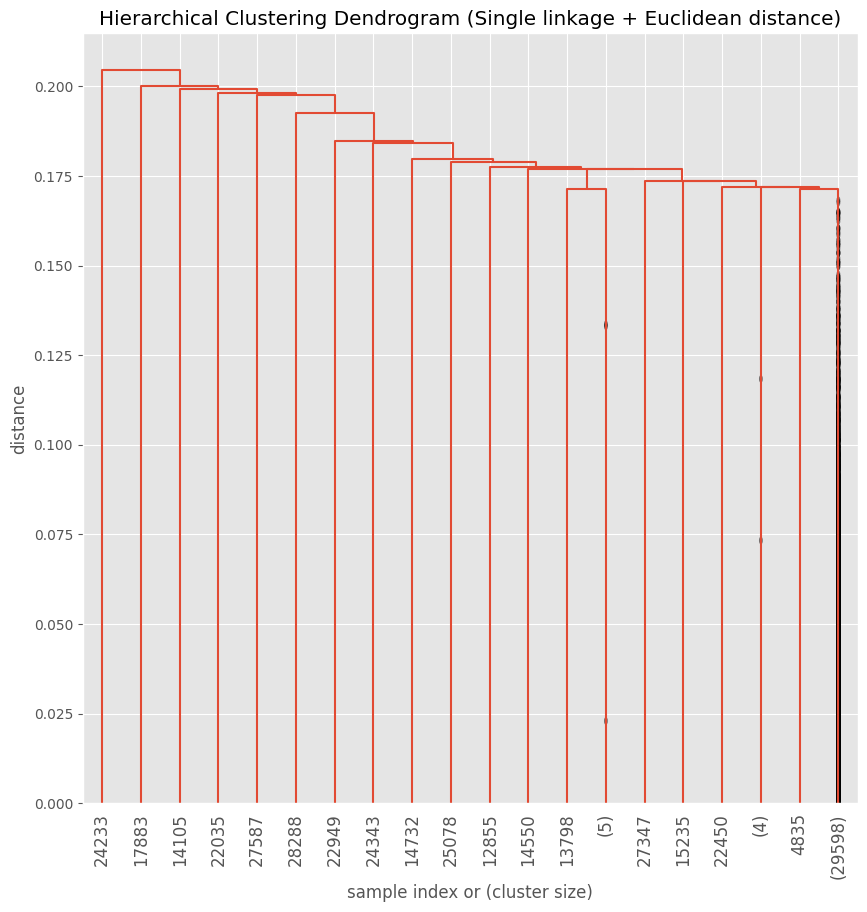

In [ ]:
# quedarnos con las últimas p uniones
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,  # useful in small plots so annotations don't overlap
    #max_d=d_max,  # plot a horizontal cut-off line
)
plt.title('Hierarchical Clustering Dendrogram (Single linkage + Euclidean distance)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.show()

#### Eliminación de outliers

In [ ]:
#Dimensiones dataset:
len(fn)

29624

In [ ]:
#Se eliminan los outliers detectados:
outliers_deuc = [24233,17883,14105,22035,27587,28288,22949,24343,14732,25078,12855,14550,13798,27347,15235,22450,4835]
fn_2 = fn
fn_2 = np.delete(fn_2,outliers_deuc,axis=0)

In [ ]:
#Dimensiones eliminando los outliers:
len(fn_2)

29607

Se clusteriza con el nuevo dataset para observar si aparecen más outliers:

In [ ]:
#Se recalcula sin los outliers:
from scipy.cluster.hierarchy import dendrogram, linkage
np.set_printoptions(precision=5, suppress=True)
plt.rcParams['figure.figsize'] = [10, 10]
Z = linkage(fn_2,method='single',metric='euclidean')   #euclidean; cityblock (Manhattan)
Z[:5]

array([[    0., 26275.,     0.,     2.],
       [ 3646.,  8846.,     0.,     2.],
       [10301., 29608.,     0.,     3.],
       [10641., 29609.,     0.,     4.],
       [ 5600., 25334.,     0.,     2.]])

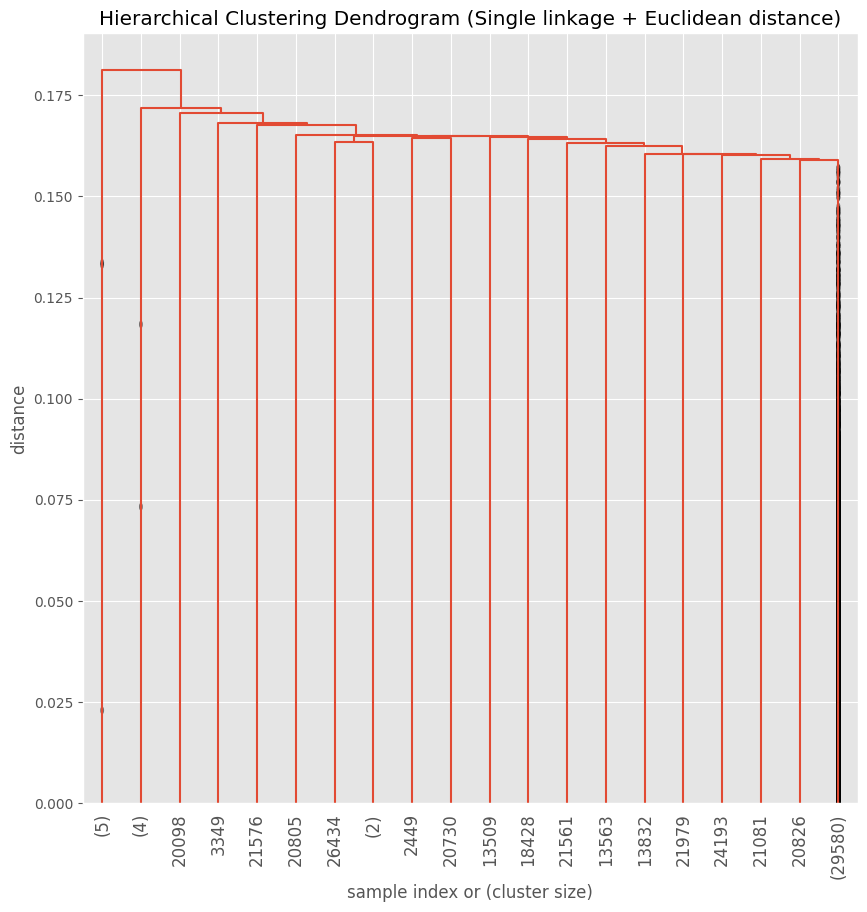

In [ ]:
# quedarnos con las últimas p uniones
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,  # useful in small plots so annotations don't overlap
    #max_d=d_max,  # plot a horizontal cut-off line
)
plt.title('Hierarchical Clustering Dendrogram (Single linkage + Euclidean distance)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.show()

## CLUSTERING **JERÁRQUICO** (Single linkage + distancia Manhattan)

Se va a clusterizar con el método single (disimilitud mínima) y la distancia de Manhattan.

In [ ]:
np.set_printoptions(precision=5, suppress=True)
plt.rcParams['figure.figsize'] = [10, 10]
Z = linkage(fn,method='single',metric='cityblock')   #euclidean; cityblock (Manhattan)
Z[:5]

array([[    0., 26289.,     0.,     2.],
       [ 3646.,  8847.,     0.,     2.],
       [10302., 29625.,     0.,     3.],
       [10642., 29626.,     0.,     4.],
       [ 5601., 25348.,     0.,     2.]])

In [ ]:
muestras = Z[0][:2]   #Del primer elemento del array se seleccionan los dos primeros números.

lst_muestras = []
for i in muestras:
  lst_muestras.append(int(i))

fn[lst_muestras]

array([[0.0739, 0.    , 0.    , 0.    , 0.    , 0.    , 0.9261],
       [0.0739, 0.    , 0.    , 0.    , 0.    , 0.    , 0.9261]])

**IMPORTANTE**: No se puede calcular el coeficiente de correlación siguiente porque no se dispone de RAM suficiente.

In [ ]:
# from scipy.cluster.hierarchy import cophenet
# from scipy.spatial.distance import pdist

# # pdist calcula las distancias entre elementos de nuestro dataset usando la métrica indicada (euclídea por defecto)
# #c, coph_dists = cophenet(Z,pdist(data_70))
# c, coph_dists = cophenet(Z,pdist(fn,metric='cityblock'))   #Usando la misma métrica que en el clustering.
# print(c)

Bondad del cluster mediante el coeficiente de correlación Cophenetic: coeficiente que mide la fidelidad con la que el dendrograma conserva las distancias por pares entre puntos de datos originales sin modelar. Esta función correla/compara las distancias reales entre todas las muestras del dataset con aquellas que implica el clustering obtenido. Cuanto más cerca de 1 mejor preserva el clustering las distancias originales, por lo que mejor es el clustering.

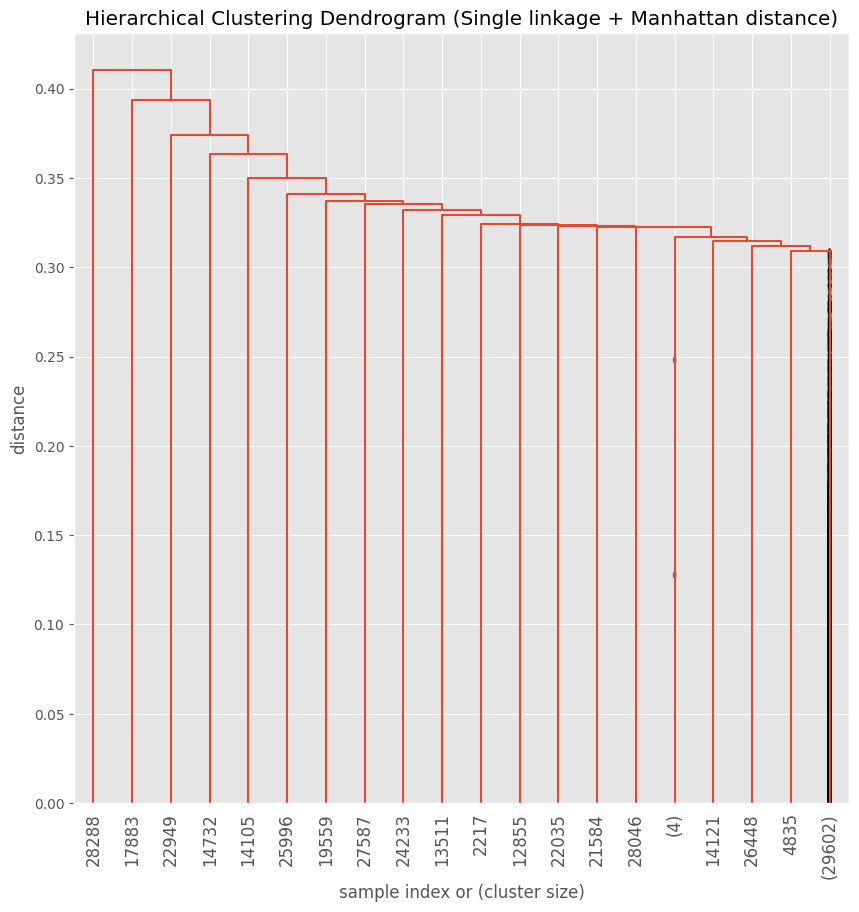

In [ ]:
# quedarnos con las últimas p uniones
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,  # useful in small plots so annotations don't overlap
    #max_d=d_max,  # plot a horizontal cut-off line
)
plt.title('Hierarchical Clustering Dendrogram (Single linkage + Manhattan distance)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.show()

#### Eliminación de outliers

In [ ]:
#Dimensiones eliminando los outliers:
len(fn)

29624

In [ ]:
#Se eliminan los outliers detectados:
outliers_dMan = [28288,17883,22949,14732,14105,25996,19559,27587,24233,13511,2217,12855,22035,21584,28046,14121,26448,4835]
fn_2 = fn
fn_2 = np.delete(fn_2,outliers_dMan,axis=0)

In [ ]:
#Dimensiones eliminando los outliers:
len(fn_2)

29606

Se clusteriza con el nuevo dataset para observar si aparecen más outliers:

In [ ]:
#Se recalcula sin los outliers:
from scipy.cluster.hierarchy import dendrogram, linkage
np.set_printoptions(precision=5, suppress=True)
plt.rcParams['figure.figsize'] = [10, 10]
Z = linkage(fn_2,method='single',metric='cityblock')   #euclidean; cityblock (Manhattan)
Z[:5]

array([[    0., 26275.,     0.,     2.],
       [ 3645.,  8845.,     0.,     2.],
       [10300., 29607.,     0.,     3.],
       [10640., 29608.,     0.,     4.],
       [ 5599., 25335.,     0.,     2.]])

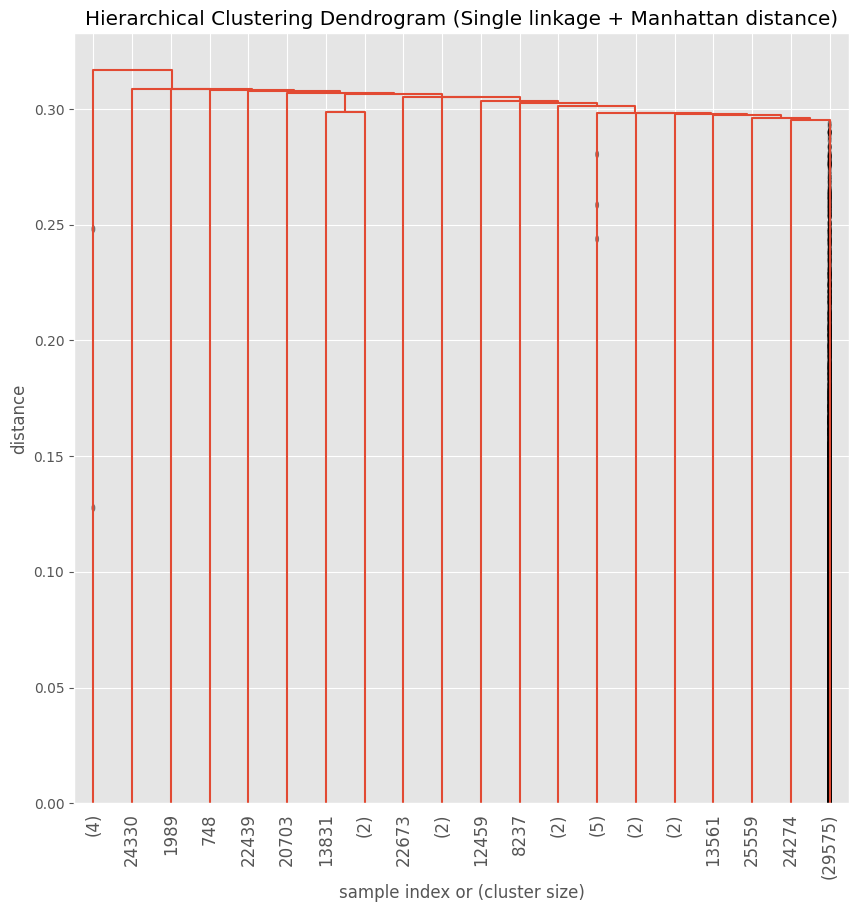

In [ ]:
# quedarnos con las últimas p uniones
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,  # useful in small plots so annotations don't overlap
    #max_d=d_max,  # plot a horizontal cut-off line
)
plt.title('Hierarchical Clustering Dendrogram (Single linkage + Manhattan distance)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
plt.show()

## ELIMINACIÓN DE OUTLIERS DETECTADOS CON CLUSTERING JERÁRQUICO

In [ ]:
# outliers_deuc = [24233,17883,14105,22035,27587,28288,22949,24343,14732,25078,12855,14550,13798,27347,15235,22450,4835]
# outliers_dMan = [28288,17883,22949,14732,14105,25996,19559,27587,24233,13511,2217,12855,22035,21584,28046,14121,26448,4835]

In [ ]:
#Se unifican los outliers detectados en ambos métodos:
outliers = []
for i in outliers_deuc:
  if i in outliers_dMan:
    outliers.append(i)
outliers

for i in outliers_dMan:
  if i in outliers_deuc:
    outliers.append(i)

outliers

[24233,
 17883,
 14105,
 22035,
 27587,
 28288,
 22949,
 14732,
 12855,
 4835,
 28288,
 17883,
 22949,
 14732,
 14105,
 27587,
 24233,
 12855,
 22035,
 4835]

In [ ]:
len(fn)

29624

In [ ]:
#Se eliminan los outliers comunes:
fn_2 = fn
fn_2 = np.delete(fn_2,outliers,axis=0)

In [ ]:
len(fn_2)

29614

Se obtienen los datos de los outliers:

In [ ]:
df_out = df.iloc[outliers]
df_out

,HKE,JAX,LEZ,MAC,OTROS,SQI,WHB
46695,21.99,17.18,0.00,43.64,0.00,0.00,17.18
34112,1.87,2.98,1.03,36.43,15.17,25.80,16.72
27150,24.45,0.00,15.99,23.51,0.00,0.00,36.05
42371,0.00,21.79,38.91,0.00,0.00,0.00,39.30
53534,26.67,16.67,31.67,25.00,0.00,0.00,0.00
54615,3.42,0.00,8.56,42.81,0.00,32.53,12.67
43913,15.86,20.13,0.00,0.00,0.00,46.69,17.32
28242,0.00,31.45,6.90,0.00,7.07,42.81,11.76
24714,0.00,0.00,0.00,25.00,33.69,41.31,0.00
9105,0.00,23.81,52.38,0.00,0.00,23.81,0.00


## CLUSTERING CON ALGORITMO **DBSCAN**

### Con **fn**

In [ ]:
dbscan = DBSCAN(eps=0.12,min_samples=200,metric='euclidean')
clusters = dbscan.fit_predict(fn)
print(clusters[-5:])
print(len(np.unique(clusters)))

[ 0  0  1  1 -1]
8


Duración 11s.

In [ ]:
outliers_dbscan = [i for i, e in enumerate(clusters) if e == -1]
len(outliers_dbscan)

7834

In [ ]:
len(fn)

29624

In [ ]:
round((len(outliers_dbscan)/len(fn))*100,2)

26.44

In [ ]:
clusters[:5]

array([ 0,  0,  0, -1,  1])

In [ ]:
df_clusters = pd.DataFrame(clusters,columns=['Cluster_DBSCAN'])
df_clusters.head()

,Cluster_DBSCAN
0,0
1,0
2,0
3,-1
4,1


In [ ]:
df_2 = df
df_2 = df_2.reset_index()
df_2.head()

,index,HKE,JAX,LEZ,MAC,OTROS,SQI,WHB
0,2,7.39,0.00,0.00,0.0,0.00,0.0,92.61
1,5,0.00,0.00,0.00,0.0,0.00,0.0,100.00
2,8,4.91,0.00,0.00,0.0,0.00,0.0,95.09
3,11,4.96,26.94,0.00,0.0,10.64,5.7,51.76
4,14,4.54,0.00,4.01,0.0,91.45,0.0,0.00


In [ ]:
# pd.concat([df,df_clusters],axis=0)
res_DBSCAN = df_2.join(df_clusters)
res_DBSCAN.head()

,index,HKE,JAX,LEZ,MAC,OTROS,SQI,WHB,Cluster_DBSCAN
0,2,7.39,0.00,0.00,0.0,0.00,0.0,92.61,0
1,5,0.00,0.00,0.00,0.0,0.00,0.0,100.00,0
2,8,4.91,0.00,0.00,0.0,0.00,0.0,95.09,0
3,11,4.96,26.94,0.00,0.0,10.64,5.7,51.76,-1
4,14,4.54,0.00,4.01,0.0,91.45,0.0,0.00,1


In [ ]:
out_dbscan = res_DBSCAN.loc[(res_DBSCAN['Cluster_DBSCAN'] == -1)]
out_dbscan.head()

,index,HKE,JAX,LEZ,MAC,OTROS,SQI,WHB,Cluster_DBSCAN
3,11,4.96,26.94,0.00,0.00,10.64,5.70,51.76,-1
6,19,0.00,75.00,0.00,0.00,25.00,0.00,0.00,-1
8,21,0.00,21.33,0.00,1.02,6.32,2.94,68.38,-1
28,59,27.88,0.00,15.38,0.00,39.81,0.00,16.92,-1
34,75,26.46,0.00,0.00,0.00,44.29,29.25,0.00,-1


In [ ]:
res_dbscan = res_DBSCAN.loc[(res_DBSCAN['Cluster_DBSCAN'] >= 0)]
res_dbscan.head()

,index,HKE,JAX,LEZ,MAC,OTROS,SQI,WHB,Cluster_DBSCAN
0,2,7.39,0.0,0.00,0.0,0.00,0.0,92.61,0
1,5,0.00,0.0,0.00,0.0,0.00,0.0,100.00,0
2,8,4.91,0.0,0.00,0.0,0.00,0.0,95.09,0
4,14,4.54,0.0,4.01,0.0,91.45,0.0,0.00,1
5,15,0.00,0.0,0.00,0.0,0.00,0.0,100.00,0


In [ ]:
#Exportación a Excel:
res_dbscan.to_excel('DBSCAN_52_K7.xlsx')#, index = False)
#Descomentar última parte si no queremos exportar los datos con sus índices.

In [ ]:
#Exportación a Excel:
out_dbscan.to_excel('DBSCAN_52_K7_outliers.xlsx')#, index = False)
#Descomentar última parte si no queremos exportar los datos con sus índices.

In [ ]:
print(len(outliers))
print('______________')
for i in outliers_dbscan:
  if i in outliers:
    print(i)

20
______________
4835
12855
14105
14732
17883
22035
22949
24233
27587
28288


In [ ]:
len(fn)

29624

In [ ]:
#Se eliminan los outliers detectados por este algoritmo:
fn_2 = fn
fn_2 = np.delete(fn_2,outliers_dbscan,axis=0)

In [ ]:
len(fn_2)

21790

## CLUSTERING CON ALGORITMO **CLARANS**  - K=7 (num_local = 3, max_neighbor = 6) - Eliminando los outliers detectados en clustering jerárquico (comunes en euclídea y Manhattan)

In [ ]:
data = fn_2.tolist()
num_clusters = 7
num_local = 3
max_neighbor = 6

"""!
@brief Constructor of clustering algorithm CLARANS.
@details The higher the value of maxneighbor, the closer is CLARANS to K-Medoids, and the longer is each search of a local minima.
@param[in] data: Input data that is presented as list of points (objects), each point should be represented by list or tuple.
@param[in] number_clusters: amount of clusters that should be allocated.
@param[in] numlocal: the number of local minima obtained (amount of iterations for solving the problem).
@param[in] maxneighbor: the maximum number of neighbors examined.
"""
clarans_instance = clarans(data, num_clusters, num_local, max_neighbor);

#calls the clarans method 'process' to implement the algortihm
#(ticks, result) = timedcall(clarans_instance.process);
result = clarans_instance.process();

#returns the clusters
clusters = clarans_instance.get_clusters();

#returns the medoids
medoids = clarans_instance.get_medoids();

#execution time
#print("Execution time : ", ticks, "\n");

#indexes by cluster
#print("Index of the points that are in a cluster : ",clusters)

#medoids
#print("The index of medoids that algorithm found to be best : ",medoids)


Duración 16 min.

In [ ]:
#Asignación de cluster en datos originales:
df_cluster = pd.DataFrame()

for i in range(0,len(clusters)):
  muestras = clusters[i]
  df_cl = df.iloc[muestras]
  df_cl['Cluster'] = i
  df_cluster = pd.concat([df_cluster,df_cl],axis=0)

df_cluster.head()

,HKE,JAX,LEZ,MAC,OTROS,SQI,WHB,Cluster
812,5.43,5.85,6.27,37.62,41.69,3.13,0.00,0
1043,6.07,0.00,6.81,41.36,45.76,0.00,0.00,0
1081,6.25,0.00,17.50,31.25,45.00,0.00,0.00,0
1313,2.57,2.75,11.93,29.66,50.03,0.00,3.06,0
1512,15.93,0.00,14.14,26.39,43.54,0.00,0.00,0


In [ ]:
#Datos medoides:
print('Medoids: ',medoids)
df_cluster.iloc[medoids]

Medoids:  [19924, 3857, 526, 28634, 10006, 26400, 10741]


,HKE,JAX,LEZ,MAC,OTROS,SQI,WHB,Cluster
28283,8.85,1.0,0.00,0.0,0.00,0.00,90.15,4
40791,29.25,0.0,23.13,0.0,47.62,0.00,0.00,1
14681,0.00,0.0,0.00,100.0,0.00,0.00,0.00,0
28898,0.00,0.0,0.00,0.0,5.26,0.00,94.74,6
46541,77.15,0.0,10.39,0.0,6.53,5.93,0.00,2
40950,8.06,0.0,16.13,0.0,71.77,4.03,0.00,5
52294,36.12,0.0,0.00,0.0,46.18,17.71,0.00,2


In [ ]:
#Exportación a Excel:
df_cluster.to_excel('Clarans_52_K7_3-6_(2).xlsx')#, index = False)
#Descomentar última parte si no queremos exportar los datos con sus índices.